In [1]:
files = [ 
    "/root/scratch/for/stephend/neutgen_low_8/neutvect.low.8.root",
    "/root/scratch/for/stephend/neutgen_low_1/neutvect.low.1.root",
    "/root/scratch/for/stephend/neutgen_low_6/neutvect.low.6.root",
    "/root/scratch/for/stephend/neutgen_low_7/neutvect.low.7.root",
    "/root/scratch/for/stephend/neutgen_low_9/neutvect.low.9.root",
    "/root/scratch/for/stephend/neutgen_low_5/neutvect.low.5.root",
    "/root/scratch/for/stephend/neutgen_low_2/neutvect.low.2.root",
    "/root/scratch/for/stephend/neutgen_low_3/neutvect.low.3.root",
]

filesb = [ 
    "/root/scratch/for/stephend/neutgen_low_bar_2/neutvect.low.2.root",
    "/root/scratch/for/stephend/neutgen_low_bar_5/neutvect.low.5.root",
    "/root/scratch/for/stephend/neutgen_low_bar_4/neutvect.low.4.root",
    "/root/scratch/for/stephend/neutgen_low_bar_3/neutvect.low.3.root",
    "/root/scratch/for/stephend/neutgen_low_bar_6/neutvect.low.6.root",
    "/root/scratch/for/stephend/neutgen_low_bar_1/neutvect.low.1.root",
    "/root/scratch/for/stephend/neutgen_low_bar_8/neutvect.low.8.root",
    "/root/scratch/for/stephend/neutgen_low_bar_9/neutvect.low.9.root",
    "/root/scratch/for/stephend/neutgen_low_bar_0/neutvect.low.0.root",
    "/root/scratch/for/stephend/neutgen_low_bar_7/neutvect.low.7.root",
]

In [2]:
import pyNUISANCE as pn
import pyProSelecta as pps
import pyNuHepMC as nhm
import matplotlib.pyplot as plt
import scipy

Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/t2kreweight-build/_deps/niwg-src/src/NIWG/Interface/NIWGEvent.h
   requested to autoload type niwg::NIWGParticle
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/t2kreweight-build/_deps/niwg-src/src/NIWG/Interface/NIWGEvent.h
   requested to autoload type niwg::NIWGEvent


Welcome to JupyROOT 6.30/04
Failed import of NUISANCEHEPData


In [3]:
evs = pn.EventSource({"filepaths":files})
if not evs:
    print("Error: failed to open input file")

evsb = pn.EventSource({"filepaths":filesb})
if not evsb:
    print("Error: failed to open input file")

# Collapse

In [ ]:
topo_names = ["invalid", 
              "CCQE", "CC1CPi","CC1Pi0", "CCMPi", "CCOther", 
              "NCE", "NC1CPi", "NC1Pi0", "NCMPi", "NCOther" ]
def sample_topo(ev):
    
    event = pps.event
    unit = pps.unit

    kQE = 1
    k1CPi = 2
    k1Pi0 = 3
    kMPi = 4
    kOther = 5
    
    procid = event.signal_process_id(ev)
    
    if not event.has_beam_part(ev,14) or not event.has_out_part(ev,[13,14]):
        return 0
    
    # get the primary vertex and check the first muon-flavor lepton to assign CC/NC
    for v in ev.vertices():
        if v.status() != 1:
            continue
        for p in v.particles_out():
            if p.pid() == 14:
                NC = 5
                break
            if p.pid() == 13:
                NC = 0
                break
        
    if event.num_out_part(ev,pps.pdg.kLeptons,flatten=True) > 1:
        return NC + kOther
    
    if event.num_out_part_except(ev, [13,14,2112,2212,111,211,-211,22]):
        return NC + kOther
    
    for g in event.all_out_part(ev,22):
        if g.momentum().e() > 25 * unit.MeV:
            return NC + kOther

    npi0 = event.num_out_part(ev,111)
    ncpi = event.num_out_part(ev,[211,-211], flatten=True)
    
    if (npi0 + ncpi) > 1:
        return NC + kMPi
    
    if ncpi == 1:
        return NC + k1CPi

    if npi0 == 1:
        return NC + k1Pi0

    return NC + kQE


# Don't Collapse

In [9]:
# CC plots: CC total, CCQE, CC 2p2h, CC Res pi, CC multi-pi + DIS, NC Total
# NC plot: NC total,  NC Res pi+/-, NC Res pi0, NC Coh pi0, NC multi-pi + DIS, CC Res pi
mode_categories = [
"CCQE", "CC 2p2h", "CCRes$\pi$","CCMPi+DIS", "CCOther", "NCRes$\pi^{\pm}$", "NCRes$\pi^{0}$", "NCCoh$\pi^{0}$", "NCMPi+DIS", "NCOther",
#  0          1            2          3              4                   5              6                 7           8,        9
"CCQEb", "CC 2p2hb", "CCRes$\pi$b","CCMPi+DISb", "CCOtherb", "NCRes$\pi^{\pm}$b", "NCRes$\pi^{0}$b", "NCCoh$\pi^{0}$b", "NCMPi+DISb", "NCOtherb",
#  10         11           12         13             14                  15             16                17                18,         19  
]
CC_categories = mode_categories[0:5]
NC_categories = mode_categories[5:10]
CCb_categories = mode_categories[10:15]
NCb_categories = mode_categories[15:]

nu_categories = CC_categories + NC_categories
nub_categories = CCb_categories + NCb_categories

def sample_mode(ev):
    channel_category_map = {
          100: 4,# CC_COH_nu
          150: 7,# NC_COH_nu
          200: 0,# CC_QE_nu
          250: 9,# NC_elastic_p_nu
          251: 9,# NC_elastic_n_nu
          300: 1,# CC_2p2h_nu
          400: 2,# CC_RES_ppi+_nu
          401: 2,# CC_RES_ppi0_nu
          402: 2,# CC_RES_npi+_nu
          410: 4,# CC_eta_nu
          411: 4,# CC_kaon_nu
          412: 4,# CC_1gamma_nu
          450: 5,# NC_RES_npi0_nu
          451: 6,# NC_RES_ppi0_nu
          452: 5,# NC_RES_npi+_nu
          460: 9,# NC_eta_n_nu
          461: 9,# NC_eta_p_nu
          462: 9,# NC_kaon_n_nu
          463: 9,# NC_kaon_p_nu
          464: 9,# NC_1gamma_n_nu
          465: 9,# NC_1gamma_p_nu
          500: 3,# CC_multi_pi_nu
          550: 8,# NC_multi_pi_nu
          600: 3,# CC_DIS_nu
          601: 8,# NC_DIS_nu
          125: 14,# CC_COH_nubar
          175: 17,# NC_COH_nubar
          225: 10,# CC_QE_proton_nubar
          275: 19,# NC_elastic_p_nubar
          276: 19,# NC_elastic_n_nubar
          325: 11,# CC_2p2h_nubar
          425: 12,# CC_RES_npi-_nubar
          426: 12,# CC_RES_ppi0_nubar
          427: 12,# CC_RES_ppi-_nubar
          435: 14,# CC_eta_nubar
          436: 14,# CC_kaon_nubar
          437: 14,# CC_1gamma_nubar
          475: 16,# NC_RES_npi0_nubar
          476: 16,# NC_RES_ppi0_nubar
          478: 15,# NC_RES_ppi-_nubar
          479: 15,# NC_RES_npi+_nubar
          485: 19,# NC_eta_n_nubar
          486: 19,# NC_eta_p_nubar
          487: 19,# NC_kaon_n_nubar
          488: 19,# NC_kaon_p_nubar
          489: 19,# NC_1gamma_n_nubar
          490: 19,# NC_1gamma_p_nubar
          525: 13,# CC_multi_pi_nubar
          575: 18,# NC_multi_pi_nubar
          625: 13,# CC_DIS_nubar
          675: 18,# NC_DIS_nubar
          110: 4,# CC_DIF_nu
          160: 17,# NC_DIF_nu
          135: 14,# CC_DIF_nubar
          185: 17,# NC_DIF_nubar
    }

    return channel_category_map[pps.event.signal_process_id(ev)] + 1

In [5]:
for i, (ev,_) in enumerate(evs):
    if i > 10:
        break
    print(f"event {i}, sample_mode = {sample_mode(ev)}")
    print(f"  topology = {mode_categories[sample_mode(ev)-1]}")

for i, (ev,_) in enumerate(evsb):
    if i > 10:
        break
    print(f"event {i}, sample_mode = {sample_mode(ev)}")
    print(f"  topology = {mode_categories[sample_mode(ev)-1]}")

event 0, sample_mode = 3
  topology = CCRes$\pi$
event 1, sample_mode = 1
  topology = CCQE
event 2, sample_mode = 1
  topology = CCQE
event 3, sample_mode = 3
  topology = CCRes$\pi$
event 4, sample_mode = 2
  topology = CC 2p2h
event 5, sample_mode = 7
  topology = NCRes$\pi^{0}$
event 6, sample_mode = 10
  topology = NCOther
event 7, sample_mode = 3
  topology = CCRes$\pi$
event 8, sample_mode = 1
  topology = CCQE
event 9, sample_mode = 1
  topology = CCQE
event 10, sample_mode = 3
  topology = CCRes$\pi$
event 0, sample_mode = 11
  topology = CCQEb
event 1, sample_mode = 11
  topology = CCQEb
event 2, sample_mode = 13
  topology = CCRes$\pi$b
event 3, sample_mode = 11
  topology = CCQEb
event 4, sample_mode = 12
  topology = CC 2p2hb
event 5, sample_mode = 20
  topology = NCOtherb
event 6, sample_mode = 13
  topology = CCRes$\pi$b
event 7, sample_mode = 13
  topology = CCRes$\pi$b
event 8, sample_mode = 13
  topology = CCRes$\pi$b
event 9, sample_mode = 11
  topology = CCQEb
event

In [6]:
fg = pn.EventFrameGen(evs) \
    .add_column("enu_GeV", pps.ext.enu_GeV) \
    .add_uint16_column("sample_mode", sample_mode)

fgb = pn.EventFrameGen(evsb) \
    .add_column("enu_GeV", pps.ext.enu_GeV) \
    .add_uint16_column("sample_mode", sample_mode)

In [16]:
import pyarrow as pa
import os

def read_or_cache(fg, name):
    #memory map it off disk if you've already written it
    if os.path.isfile(name) and True:
        with pa.memory_map(name, 'rb') as source:
           return pa.ipc.open_file(source).read_all()
    else:
        bchunk = fg.firstArrow(int(2.5E5))
        with pa.OSFile(name, 'wb') as sink:
            with pa.ipc.new_file(sink, bchunk.schema) as writer:
                while bchunk:
                    writer.write_batch(bchunk)
                    print("wrote 2.5E5 rows...")
                    bchunk = fg.nextArrow()
        return read_or_cache(fg, name)
        
ttbl = read_or_cache(fg, "fortailin.arrow")
ttblb = read_or_cache(fgb, "fortailinb.arrow")

In [11]:
import copy
import numpy as np

def smooth(hist, binning):
    x_in = pn.Binning.get_bin_centers1D(hist.binning.bins)
    x_out = pn.Binning.get_bin_centers1D(binning.bins)

    sumw_out = np.empty(shape=(len(x_out),len(hist.column_info)))
    
    hist_out = pn.HistFrame(binning)
    for coli in hist.column_info:
        coln = coli.name
        ci = hist.find_column_index(coln)
        co = hist_out.find_column_index(coln)
        if co == pn.BinnedValuesBase.npos:
            co = hist_out.add_column(coln)
        y_in = hist.sumweights[:,ci]
        smooth_interp = scipy.interpolate.CubicSpline(x_in, y_in)

        for i,x in enumerate(x_out):
            sumw_out[i,ci] = smooth_interp(x)

    hist_out.sumweights = sumw_out
    return hist_out

def getxsec_GeV(enu_GeV_hist, flux, per_enu=False):
    flux.set_units("GEV")

    flux_bin_centers = flux.get_bin_centers()
    flux_shape_interp = scipy.interpolate.CubicSpline(flux.get_bin_centers(), flux.get_flux_shape_density())

    sumw = enu_GeV_hist.sumweights.copy()
    var = enu_GeV_hist.variances.copy()
    num_rows, num_cols = sumw.shape

    for ri,b in enumerate(enu_GeV_hist.binning.bins):
        enu_ext = b[0]
        
        #only cover bins in in the input flux
        if( (enu_ext.high < flux.bin_edges[0]) or (flux.bin_edges[-1] < enu_ext.low) ):
            continue

        frac_of_flux_averaged_nu = ((flux_shape_interp(enu_ext.low) + flux_shape_interp(enu_ext.high))/2.0) * (enu_ext.high - enu_ext.low)

        scale_factor = 1.0/frac_of_flux_averaged_nu
        if(per_enu):
            scale_factor /= ((enu_ext.low + enu_ext.high)/2.0)
        
        for ci in range(num_cols):
            sumw[ri,ci] *= scale_factor
            var[ri,ci] *= scale_factor*scale_factor

    xsec_hist = copy.copy(enu_GeV_hist)
    xsec_hist.sumweights = sumw
    xsec_hist.variances = var

    return xsec_hist

def make_xsec_hist(hist, chunk, fatx, sumw, flux, sample_column_name, category_columns):
    if not hist: hist = pn.HistFrame(pn.Binning.log10_space(0.1,10,50))
    hist.reset()
    
    for c in category_columns:
        if hist.find_column_index(c) == pn.BinnedValuesBase.npos:
            hist.add_column(c)

    hist.fill_columns_from_Arrow(chunk, ["enu_GeV"], sample_column_name)

    # fatx is in pb/A, but A is probably oxygen. x 16/18 to take it to /H20
    sf = (fatx/sumw) * (1.0E2/16.0) * (16.0/18.0)

    xsec = getxsec_GeV(hist, flux, True)
    xsec.sumweights *= sf
    xsec.variances *= sf*sf

    return xsec

In [22]:
flux = nhm.ReaderUtils.GC7.read_energy_distribution(evs.run_info(),14)

fatx = ttbl["fatx.estimate"][ttbl.num_rows-1].as_py()
sumw = ttbl.num_rows

xsec_topo = make_xsec_hist(pn.HistFrame(pn.Binning.log10_space(0.1,2,15)), ttbl, 
                           fatx, sumw, 
                           flux, "sample_mode", mode_categories)

fatxb = ttblb["fatx.estimate"][ttblb.num_rows-1].as_py()
sumwb = ttblb.num_rows

xsec_topob = make_xsec_hist(pn.HistFrame(pn.Binning.log10_space(0.1,2,15)), ttblb, 
                           fatxb, sumwb, 
                           flux, "sample_mode", mode_categories)

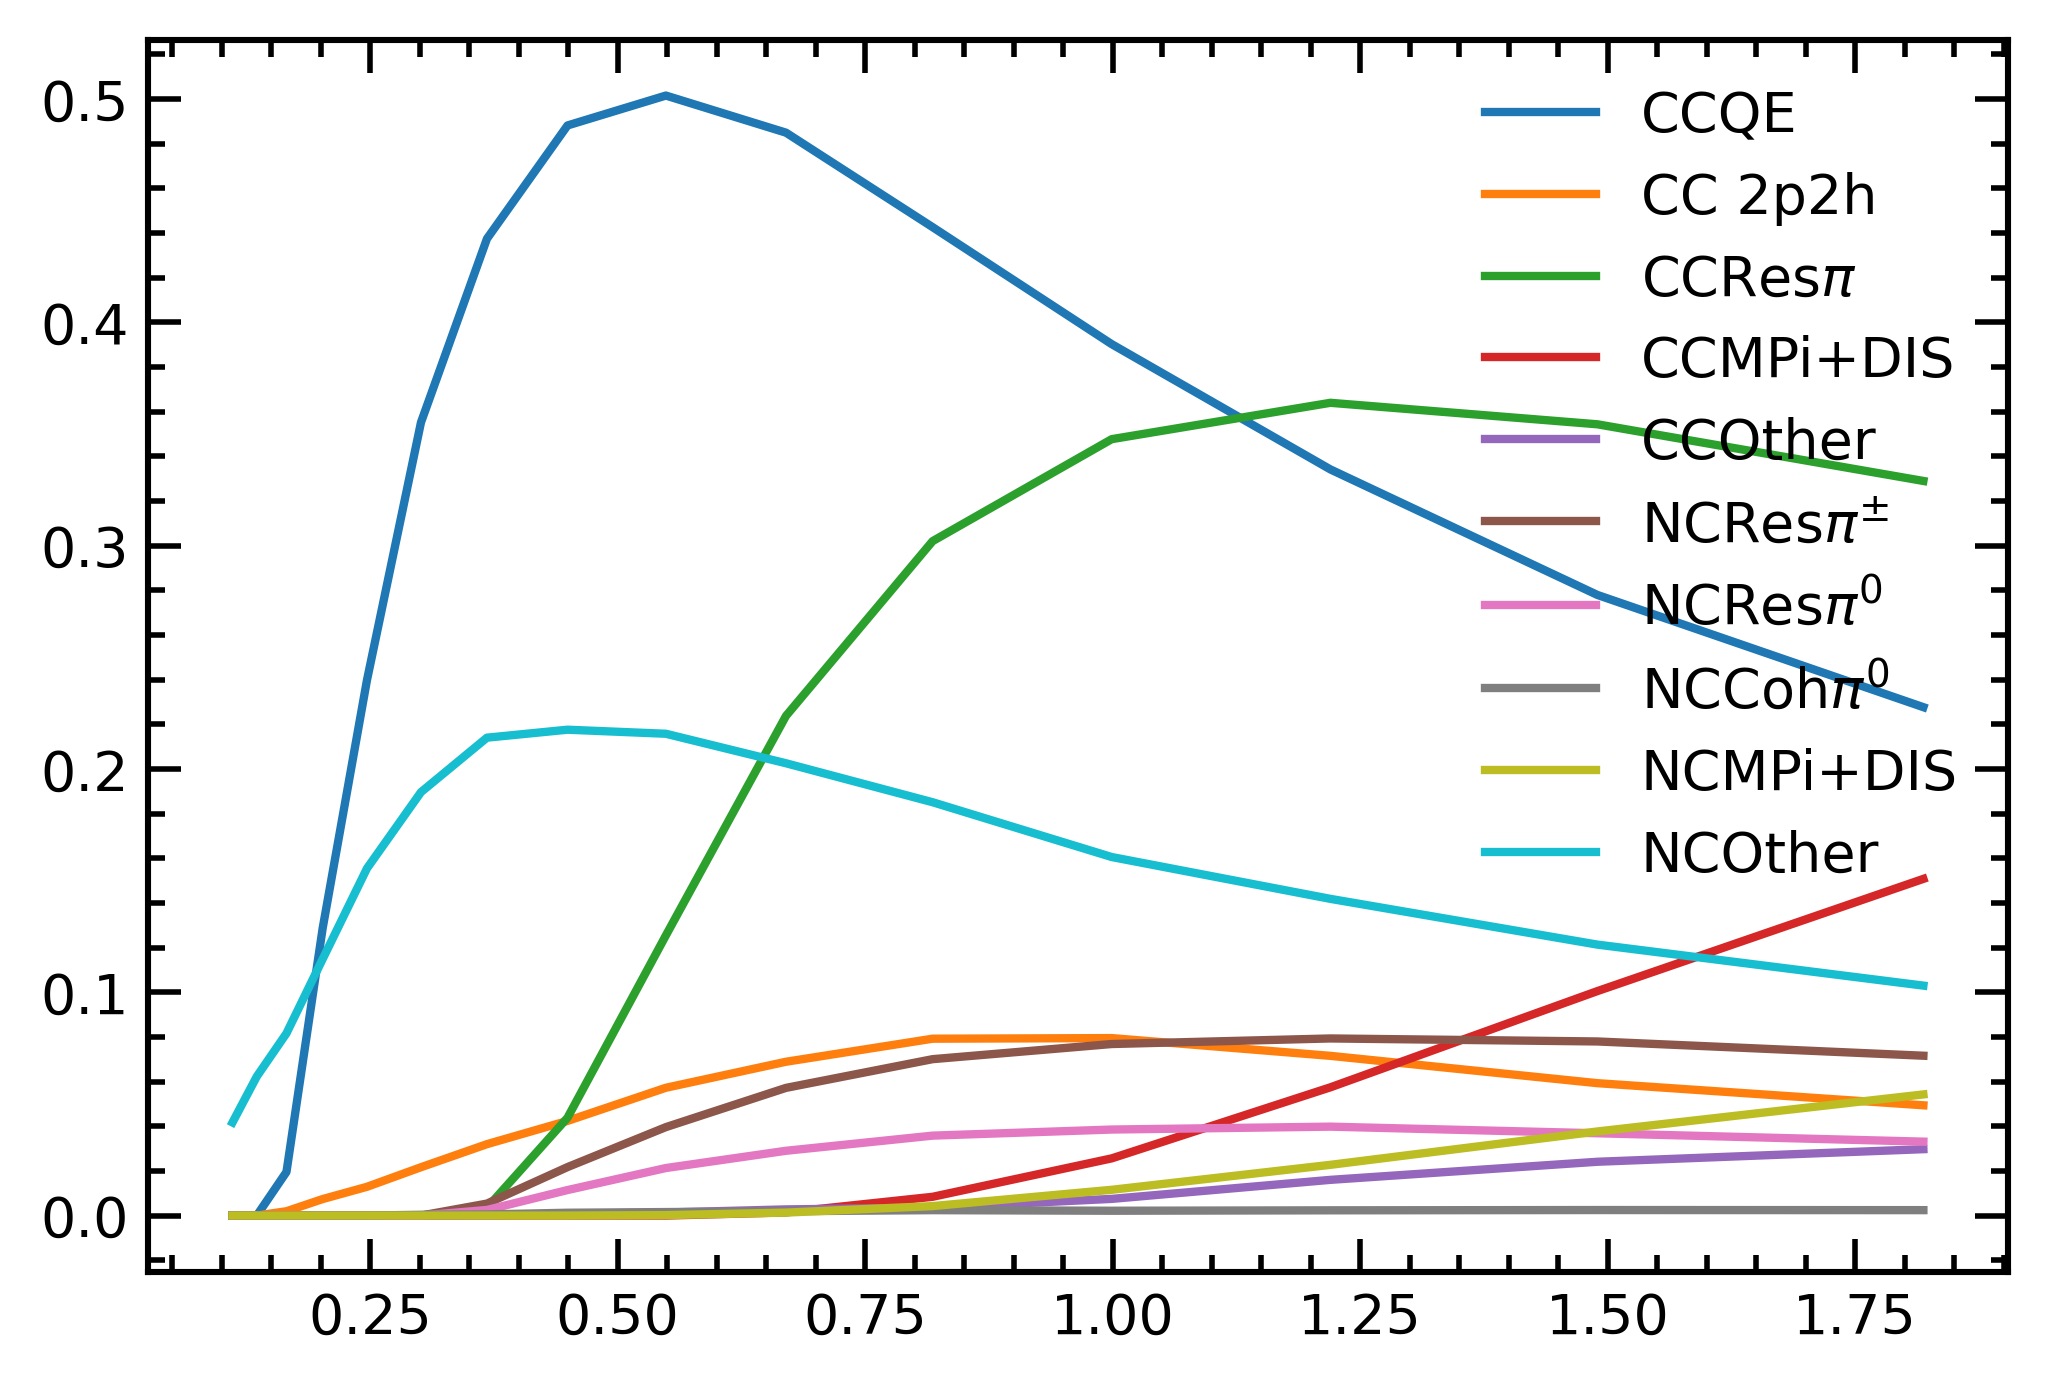

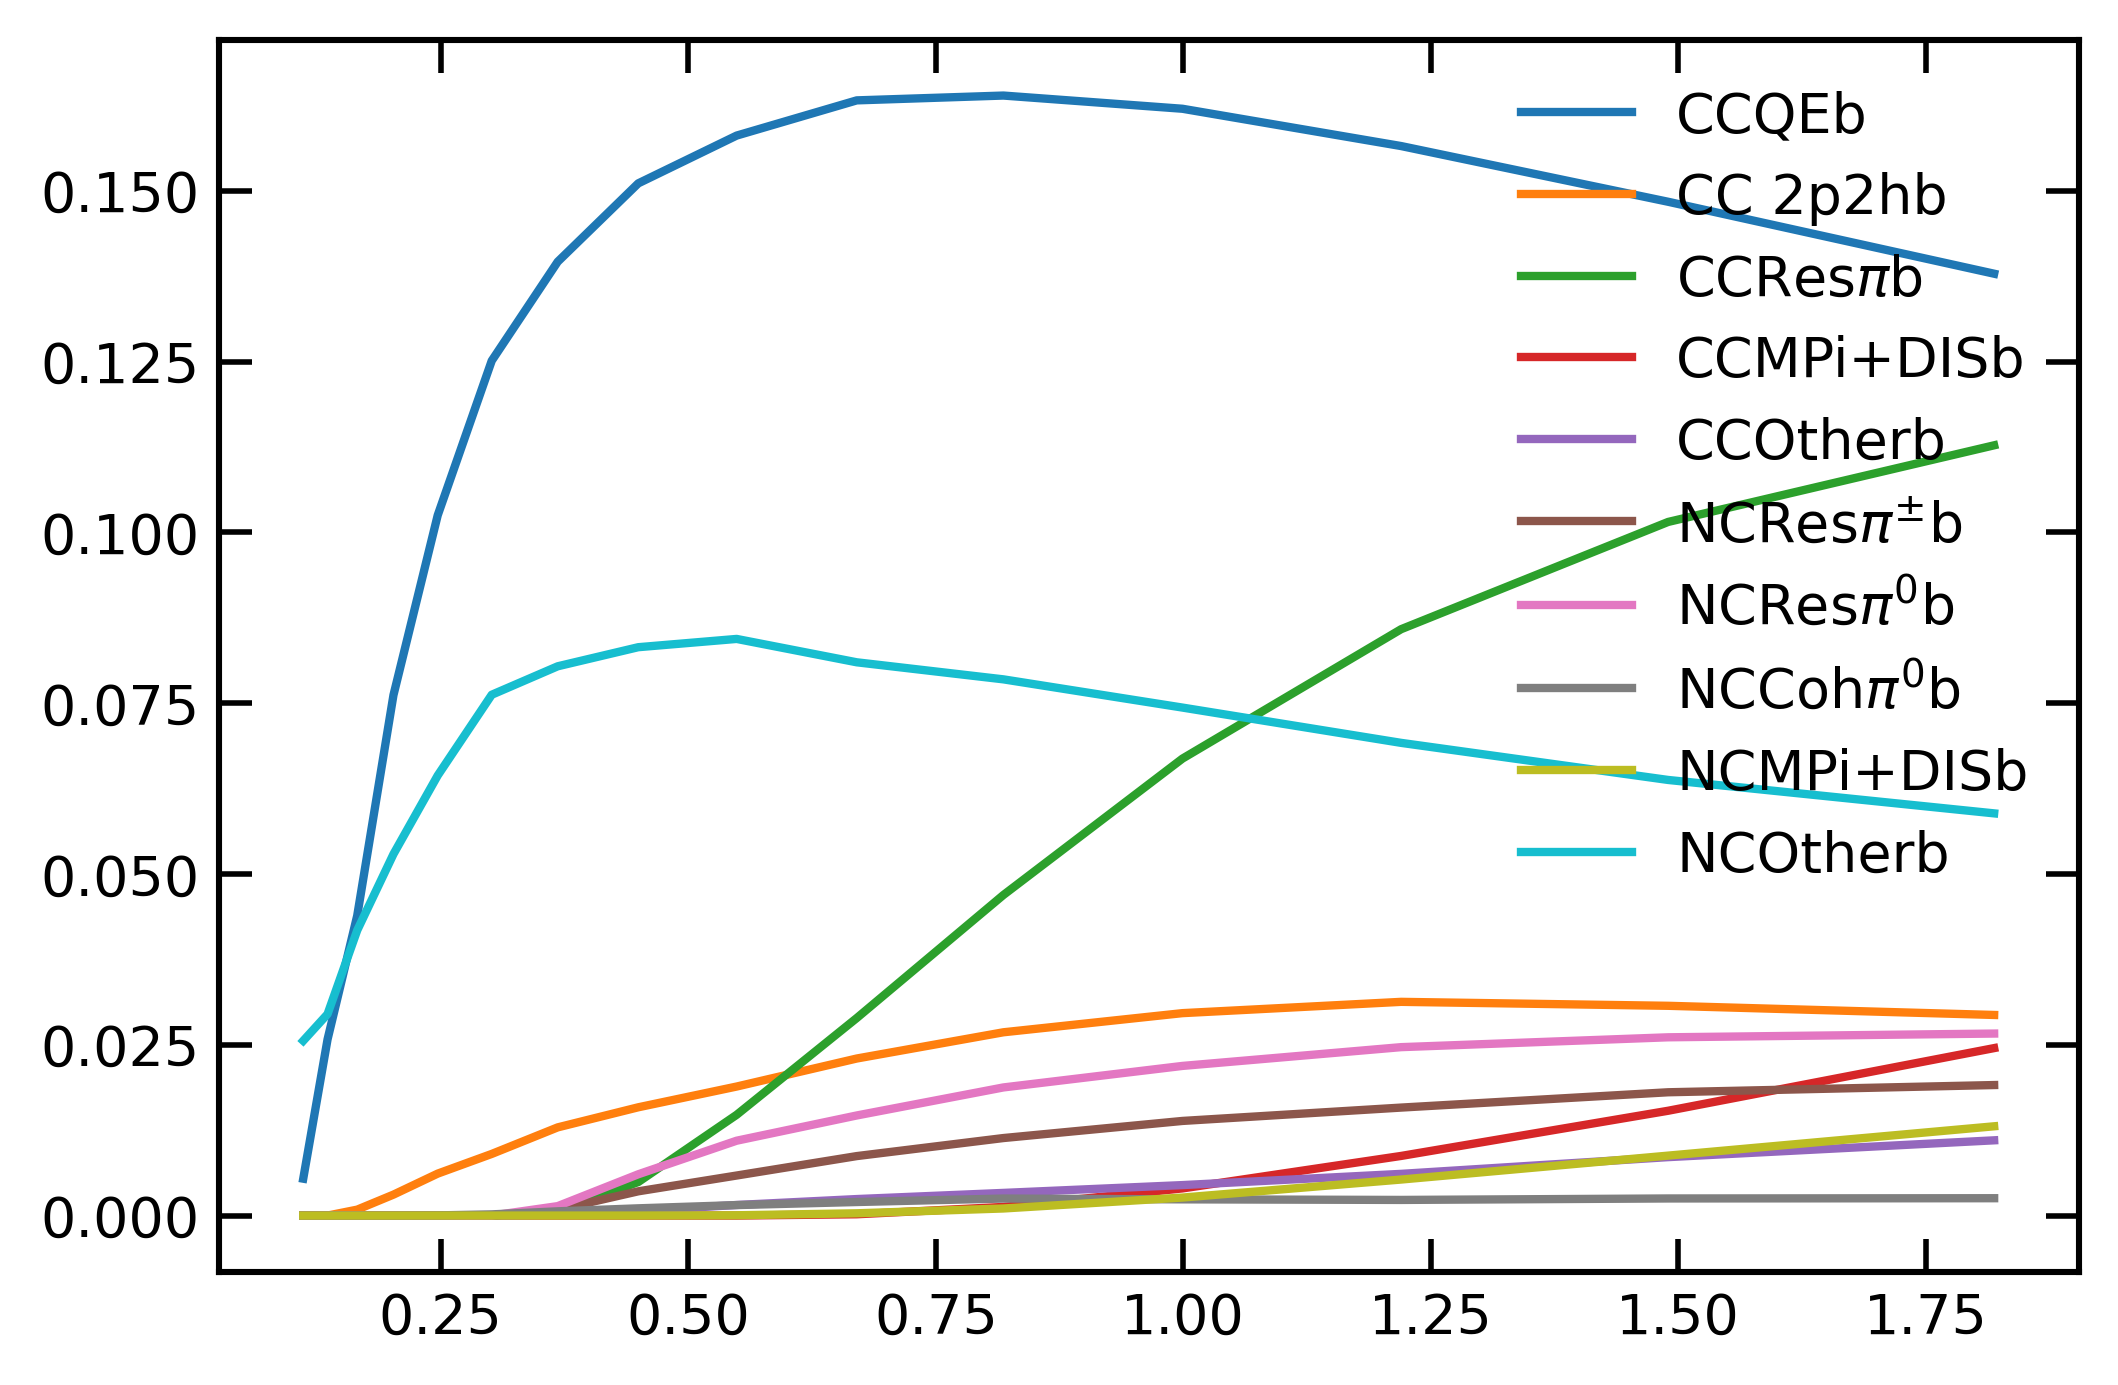

In [24]:
pn.cern([6,4])
pn.cern([6,4])

xsec_topo.mpl().plot_all(columns=nu_categories)
plt.legend()
plt.show()

xsec_topob.mpl().plot_all(columns=nub_categories)
plt.legend()
plt.show()

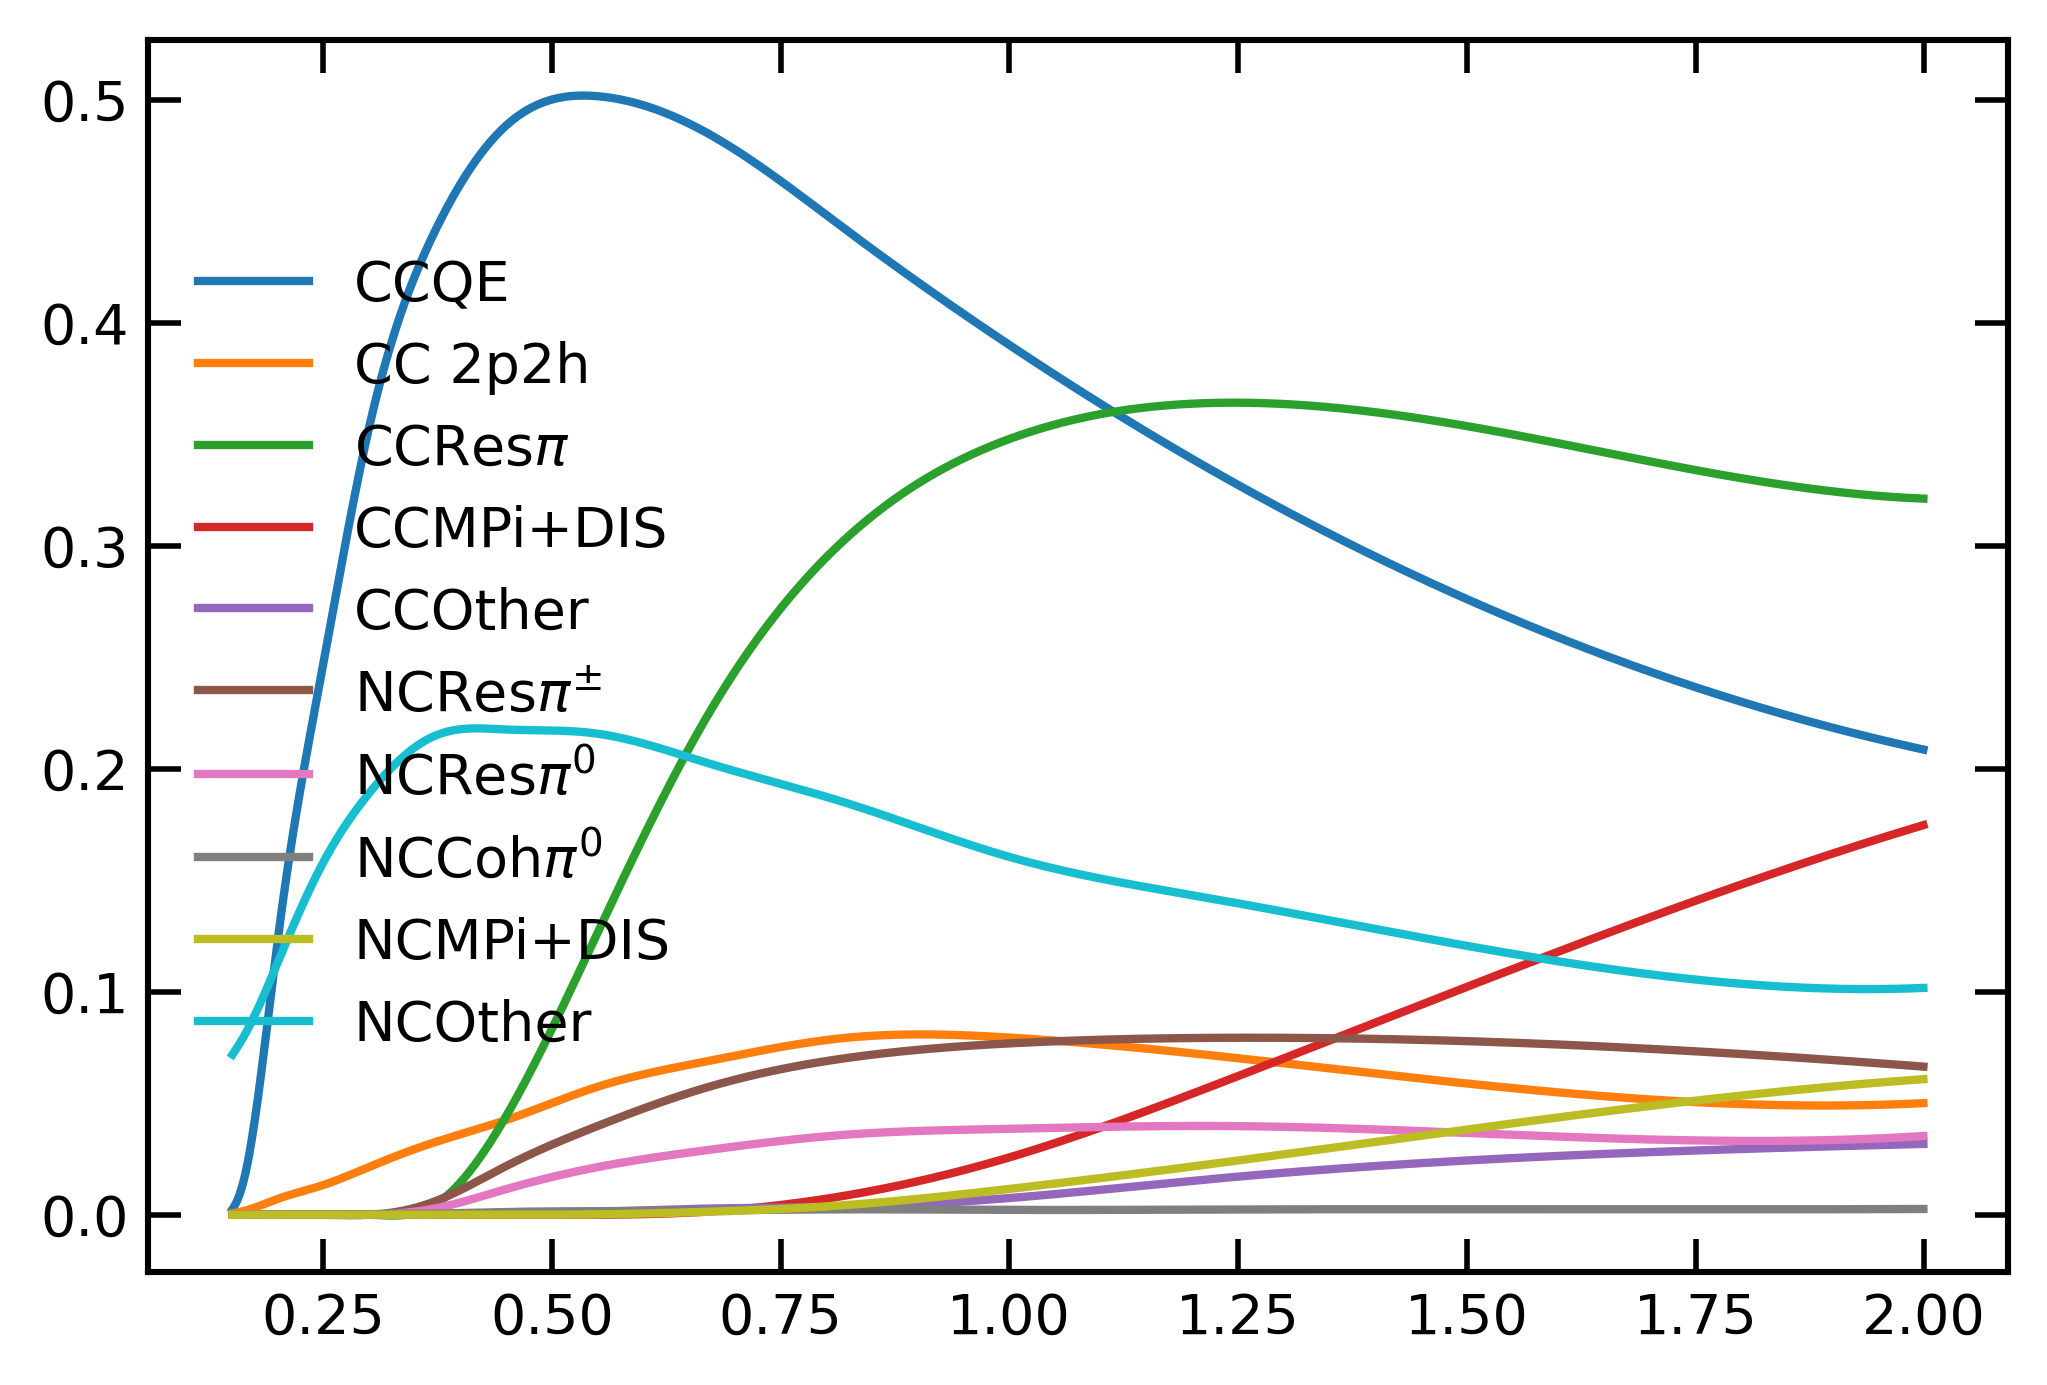

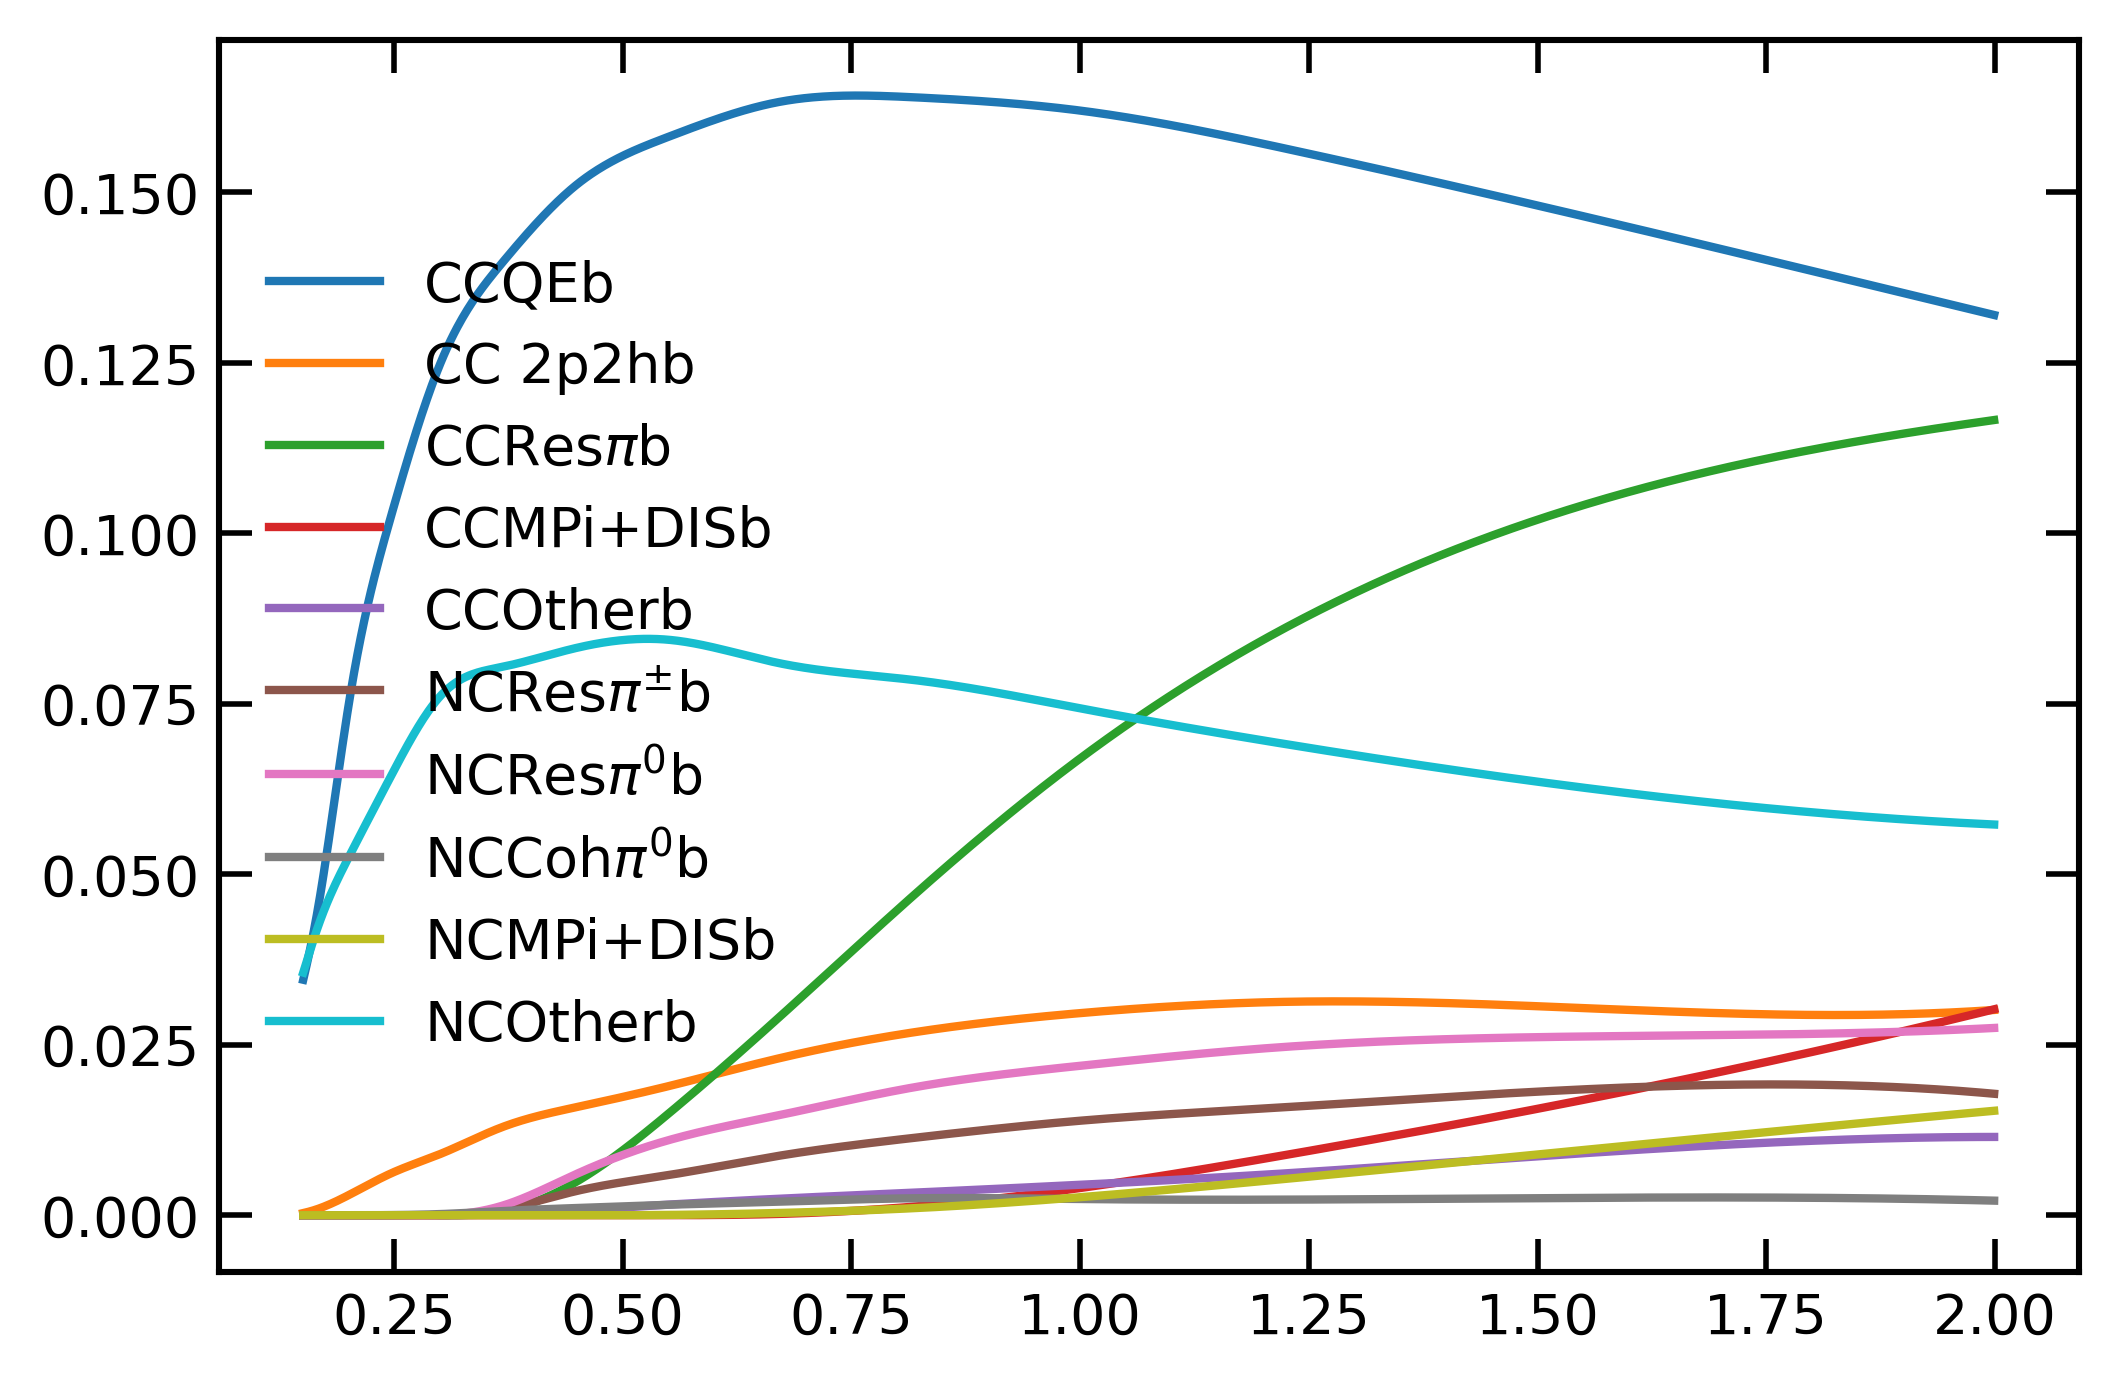

In [25]:
xsec_topo_smooth = smooth(xsec_topo, pn.Binning.lin_space(0.15,2,1000)) 

xsec_topo_smooth.mpl().plot_all(columns=nu_categories)
plt.legend()
plt.show()

xsec_topo_smoothb = smooth(xsec_topob, pn.Binning.lin_space(0.15,2,1000)) 

xsec_topo_smoothb.mpl().plot_all(columns=nub_categories)
plt.legend()
plt.show()

T2K_Flux: {energy_unit: GeV, rate_unit: Flux [/cm^{2}/50 MeV/1#times10^{21} p.o.t.]}


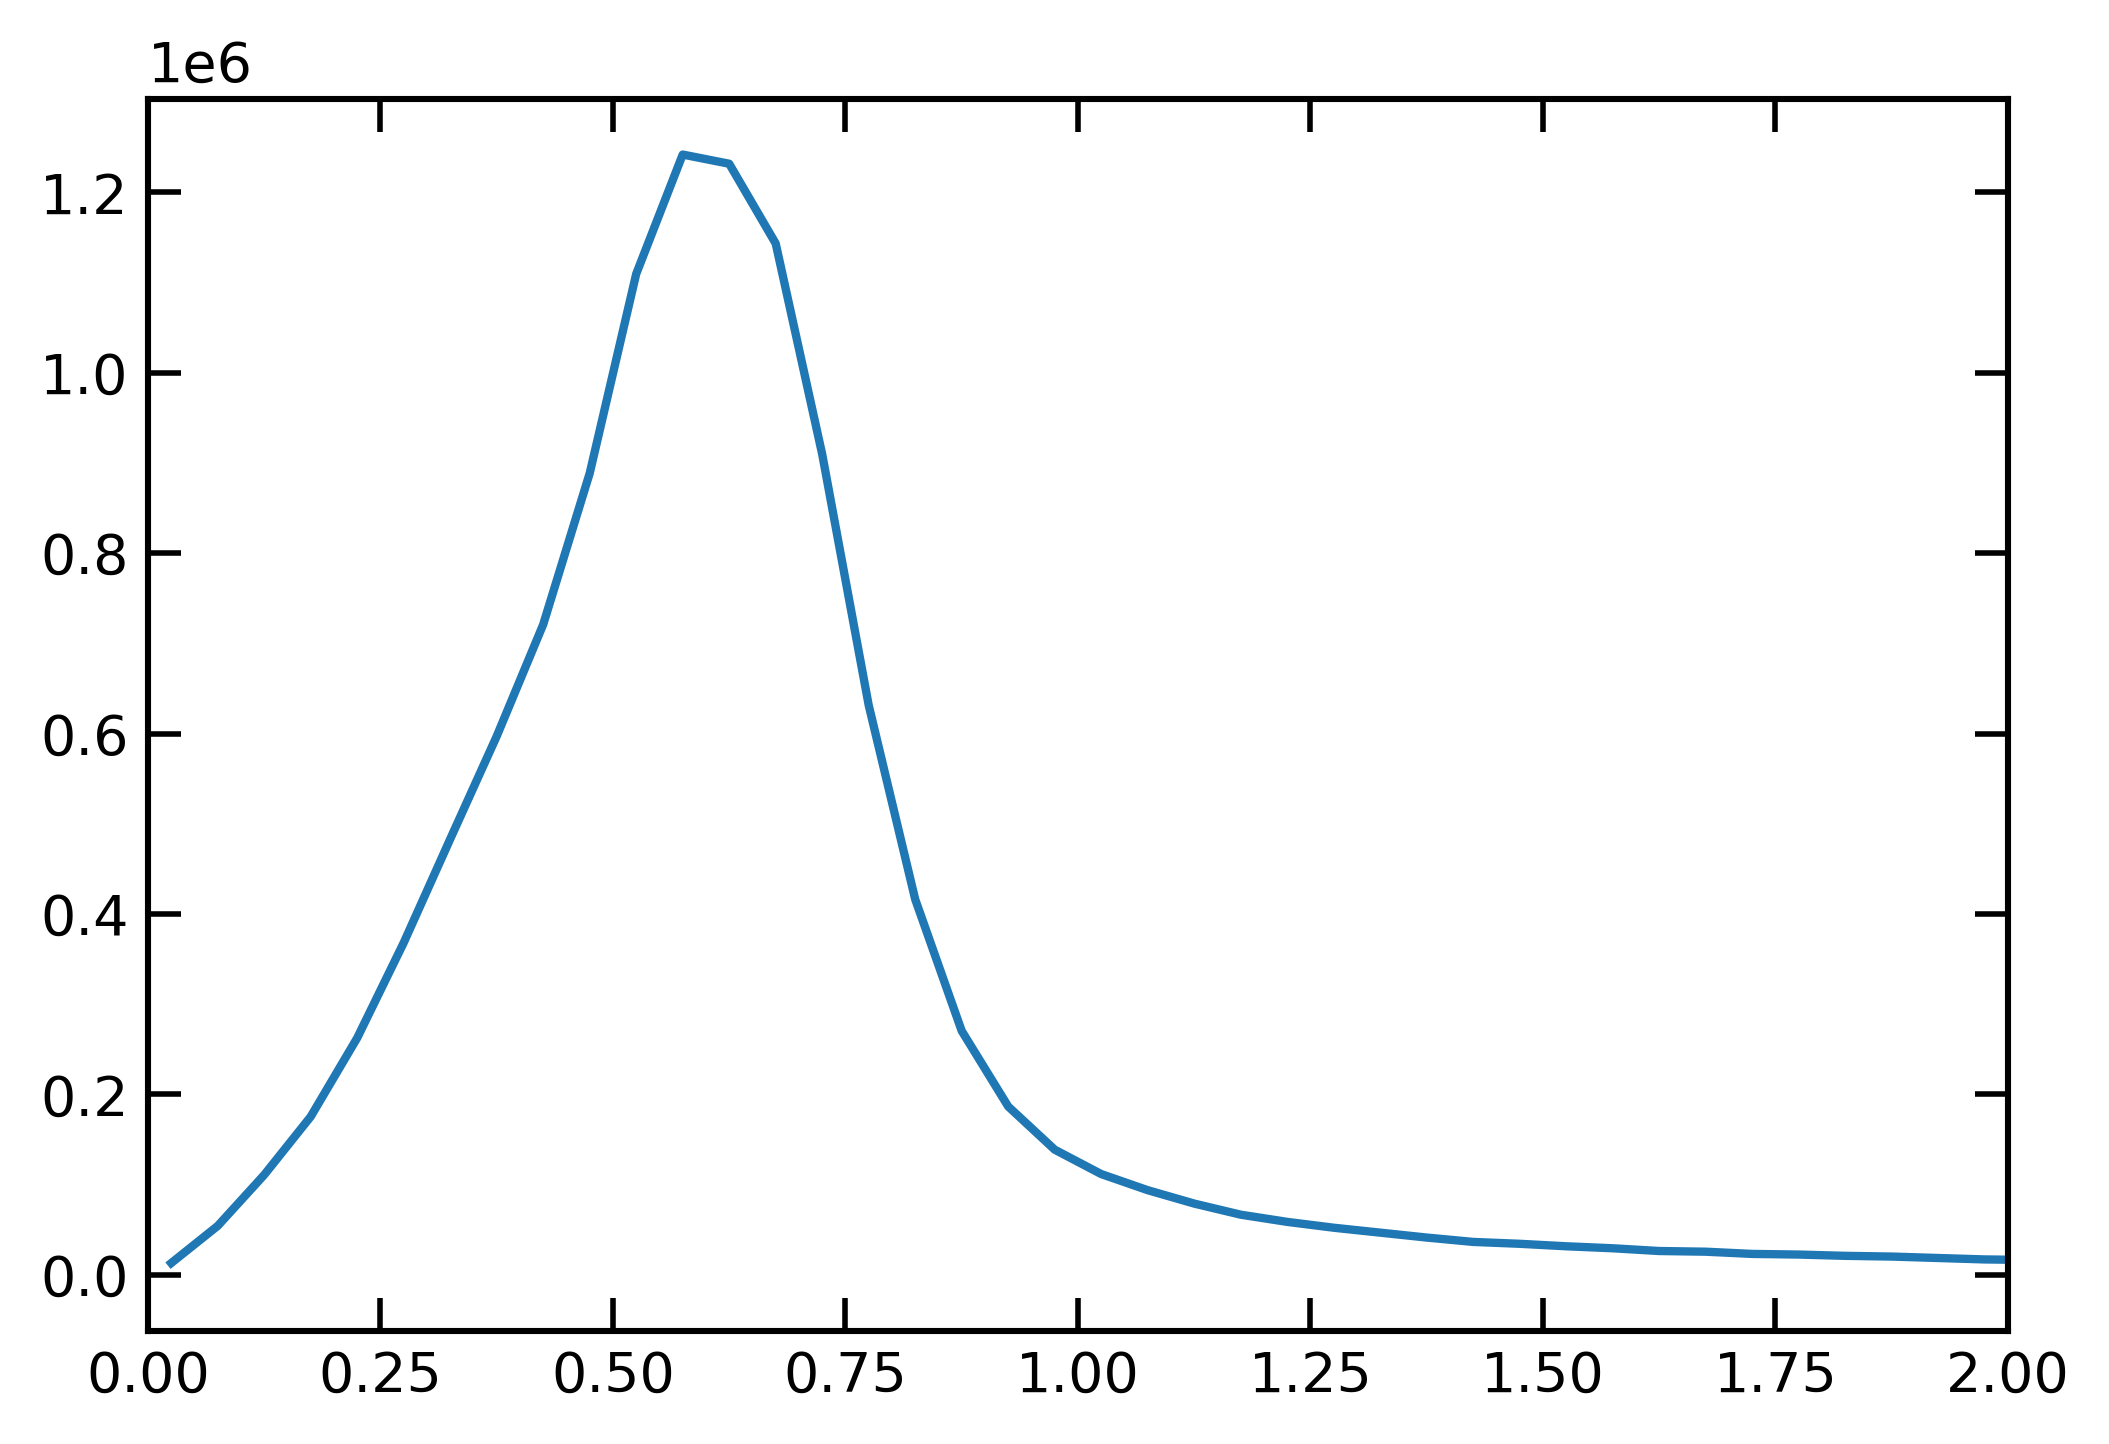

In [26]:
T2K_Flux = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/t2kflux_2016_plus250kA.root",
    "enu_sk_numu", "GeV", True)

print("T2K_Flux: {energy_unit: %s, rate_unit: %s}" % (T2K_Flux.energy_unit,T2K_Flux.rate_unit))

plt.xlim([0,2])
plt.plot(T2K_Flux.get_bin_centers(),T2K_Flux.get_flux_density())

In [27]:
def logpoints_density(flux_dist):
    bin_centers = flux_dist.get_bin_centers()
    interp = scipy.interpolate.CubicSpline(bin_centers,flux_dist.get_flux_density())
    logpoints = pn.Binning.get_bin_centers1D(pn.Binning.log10_space(bin_centers[0], bin_centers[-1], 1000).bins)
    yp = [interp(x) for x in logpoints]

    return (logpoints, yp)

def pin_to_zz(x,y):
    x.insert(0,x[0])
    y.insert(0,0)
    return (x,y)

In [54]:
t2k_logd = logpoints_density(T2K_Flux)

wnf5_disp_t2k = pn.Prob3plusplusWeightCalc()
wnf5_disp_t2k.set_parameters({"baseline_km": 295, "NuFit:5.2": 1, "osc:numu_disp":1})
wnf5_app_t2k = pn.Prob3plusplusWeightCalc()
wnf5_app_t2k.set_parameters({"baseline_km": 295, "NuFit:5.2": 1, "osc:numu_to_nue":1})

dosc_t2k = [wnf5_disp_t2k.prob(x)*y for x,y in zip(t2k_logd[0],t2k_logd[1])]
aosc_t2k = [wnf5_app_t2k.prob(x)*y for x,y in zip(t2k_logd[0],t2k_logd[1])]

t2k_logdx, t2k_logdy = pin_to_zz(t2k_logd[0],t2k_logd[1])
dosc_t2kn, aosc_t2kn = pin_to_zz(dosc_t2k,aosc_t2k)

wnf5_disp_t2kb = pn.Prob3plusplusWeightCalc()
wnf5_disp_t2kb.set_parameters({"baseline_km": 295, "NuFit:5.2": 1, "osc:from": -14,"osc:to": -14})
wnf5_app_t2kb = pn.Prob3plusplusWeightCalc()
wnf5_app_t2kb.set_parameters({"baseline_km": 295, "NuFit:5.2": 1, "osc:from": -14,"osc:to": -12})

dosc_t2kb = [wnf5_disp_t2kb.prob(x)*y for x,y in zip(t2k_logd[0],t2k_logd[1])]
aosc_t2kb = [wnf5_app_t2kb.prob(x)*y for x,y in zip(t2k_logd[0],t2k_logd[1])]

dosc_t2knb, aosc_t2knb = pin_to_zz(dosc_t2kb,aosc_t2kb)

Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!


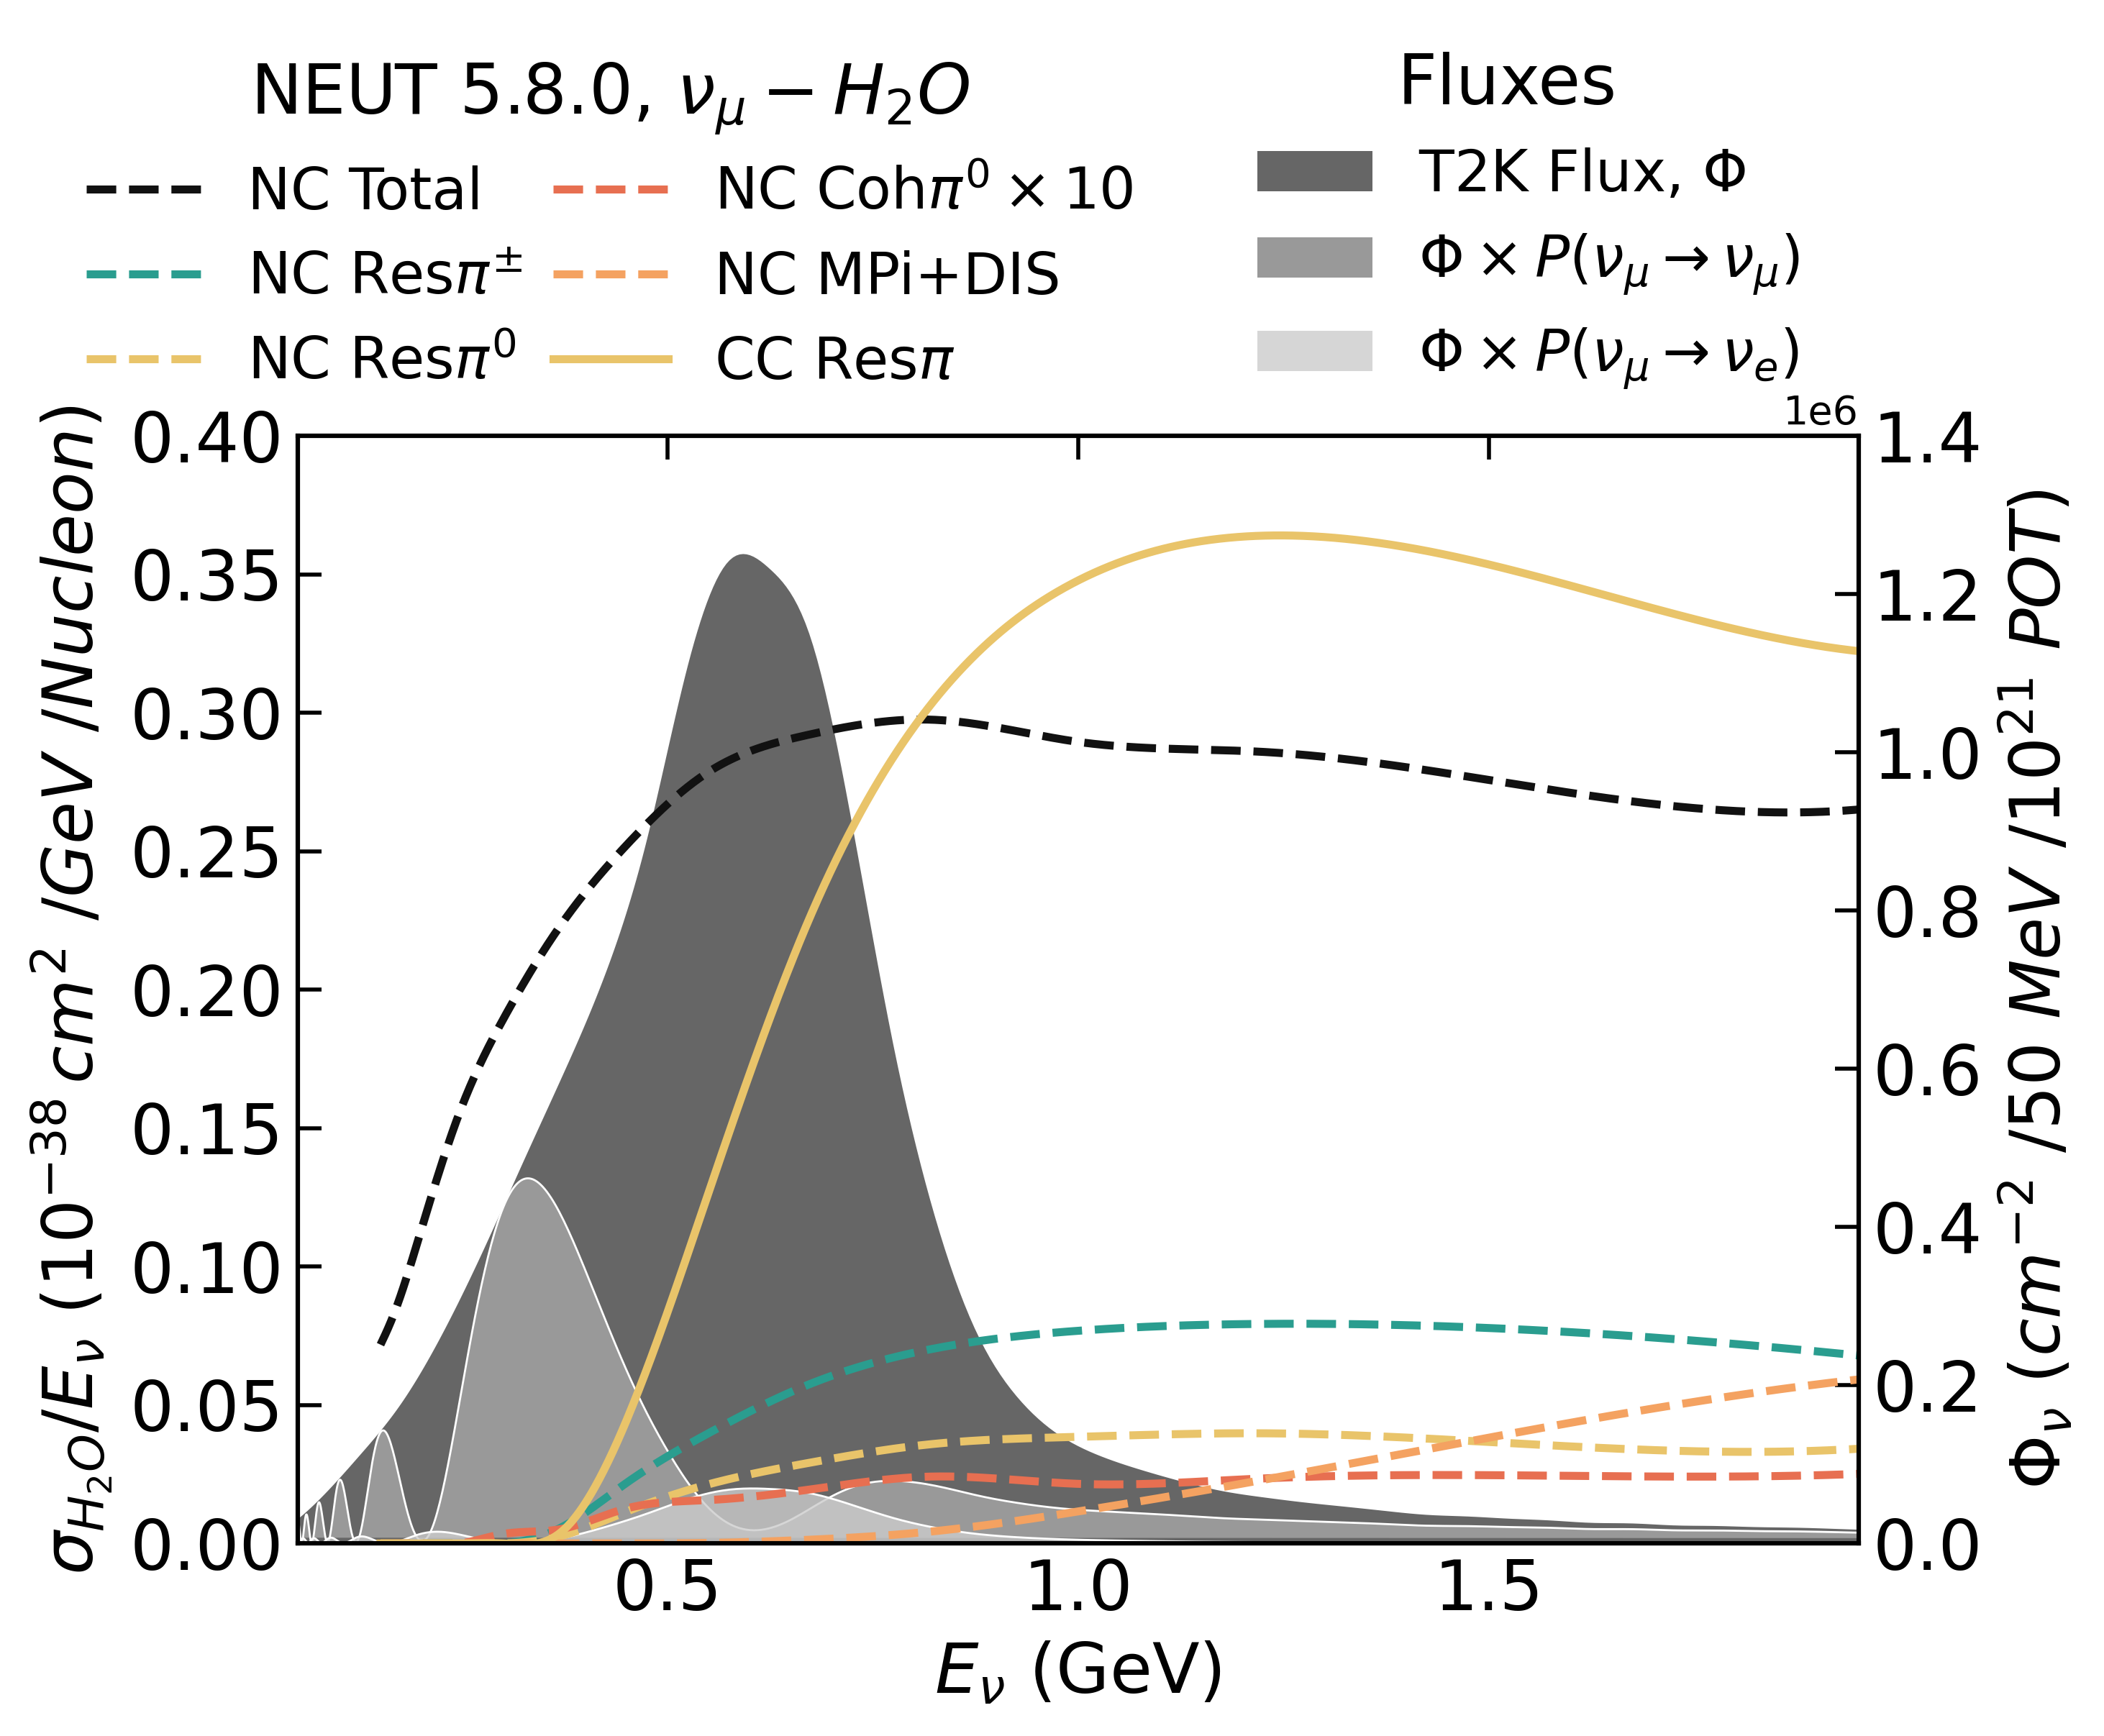

In [61]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(111)

ax1.set_xlim([0.05,1.95])
ax1.set_ylim([0,1.4E6])

ax1.fill(t2k_logdx,t2k_logdy, facecolor="#666",zorder=3, label="T2K Flux, $\Phi$")
ax1.fill(t2k_logdx,dosc_t2kn,facecolor="#999",zorder=3, label=r"$\Phi\times{P}\left(\nu_\mu\rightarrow\nu_\mu\right)$")
ax1.plot(t2k_logdx,dosc_t2kn,color="#FFF",linestyle="solid",linewidth=0.5,zorder=3)
ax1.fill(t2k_logdx,aosc_t2kn,facecolor="#cccc",zorder=4, label=r"$\Phi\times{P}\left(\nu_\mu\rightarrow\nu_{e}\right)$")
ax1.plot(t2k_logdx,aosc_t2kn,color="#FFF",linestyle="solid",linewidth=0.5,zorder=4)

ax1.legend(bbox_to_anchor=(0.6, 1.02, 0.35, .102), loc='lower left',
                      ncol=1, mode="expand", borderaxespad=0.,
          title="Fluxes", fontsize="x-large", title_fontsize="xx-large")

ax1.set_ylabel(r"$\Phi_{\nu}\ ({cm}^{-2}\ /50\ {MeV}\ /10^{21}\ {POT})$",fontsize="xx-large")
ax1.set_xlabel(r"$E_{\nu}$ (GeV)",fontsize="xx-large",loc="center")
ax1.tick_params(axis='x', labelsize="xx-large")

ax2 = ax1.twinx()
# CC plots: CC total, CCQE, CC 2p2h, CC Res pi, CC multi-pi + DIS, NC Total
# NC plot: NC total,  NC Res pi+/-, NC Res pi0, NC Coh pi0, NC multi-pi + DIS, CC Res pi
xsec_topo_smooth.mpl().plot_sum(columns=NC_categories, plot_axis=ax2, linewidth=2, color="#111", linestyle="dashed",label="NC Total")
xsec_topo_smooth.mpl().plot(column="NCRes$\pi^{\pm}$", plot_axis=ax2, linewidth=2,color="#2a9d8f", linestyle="dashed",label="NC Res$\pi^{\pm}$")
xsec_topo_smooth.mpl().plot(column="NCRes$\pi^{0}$", plot_axis=ax2, linewidth=2,color="#e9c46a", linestyle="dashed",label="NC Res$\pi^{0}$")
xsec_topo_smooth.mpl().plot(column="NCCoh$\pi^{0}$", yscale=10,plot_axis=ax2, linewidth=2,color="#e76f51", linestyle="dashed",label=r"NC Coh$\pi^{0}\times 10$")
xsec_topo_smooth.mpl().plot(column="NCMPi+DIS", plot_axis=ax2, linewidth=2,color="#f4a261", linestyle="dashed",label="NC MPi+DIS")
xsec_topo_smooth.mpl().plot(column="CCRes$\pi$", plot_axis=ax2, linewidth=2,color="#e9c46a", linestyle="solid", label="CC Res$\pi$")

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis='y', labelsize="xx-large")

ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim([0,0.4])
ax2.tick_params(axis='y', labelsize="xx-large")

ax2.set_ylabel(r"$\sigma_{{H}_{2}{O}}/E_{\nu}\ (10^{-38}\,{cm}^{2}\ /{GeV}\ /{Nucleon})$",fontsize="xx-large",loc="center")

ax2.legend(bbox_to_anchor=(-0.15, 1.02, 0.7, .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0.,
          title=r"NEUT 5.8.0, $\nu_{\mu}-{H}_{2}{O}$",
          fontsize="x-large", title_fontsize="xx-large")
mydpi=400
# plt.figure(figsize=(800/mydpi, 800/mydpi), dpi=mydpi)
plt.savefig("fortailin_mode_NC.png", bbox_inches='tight', dpi=mydpi)
plt.show()

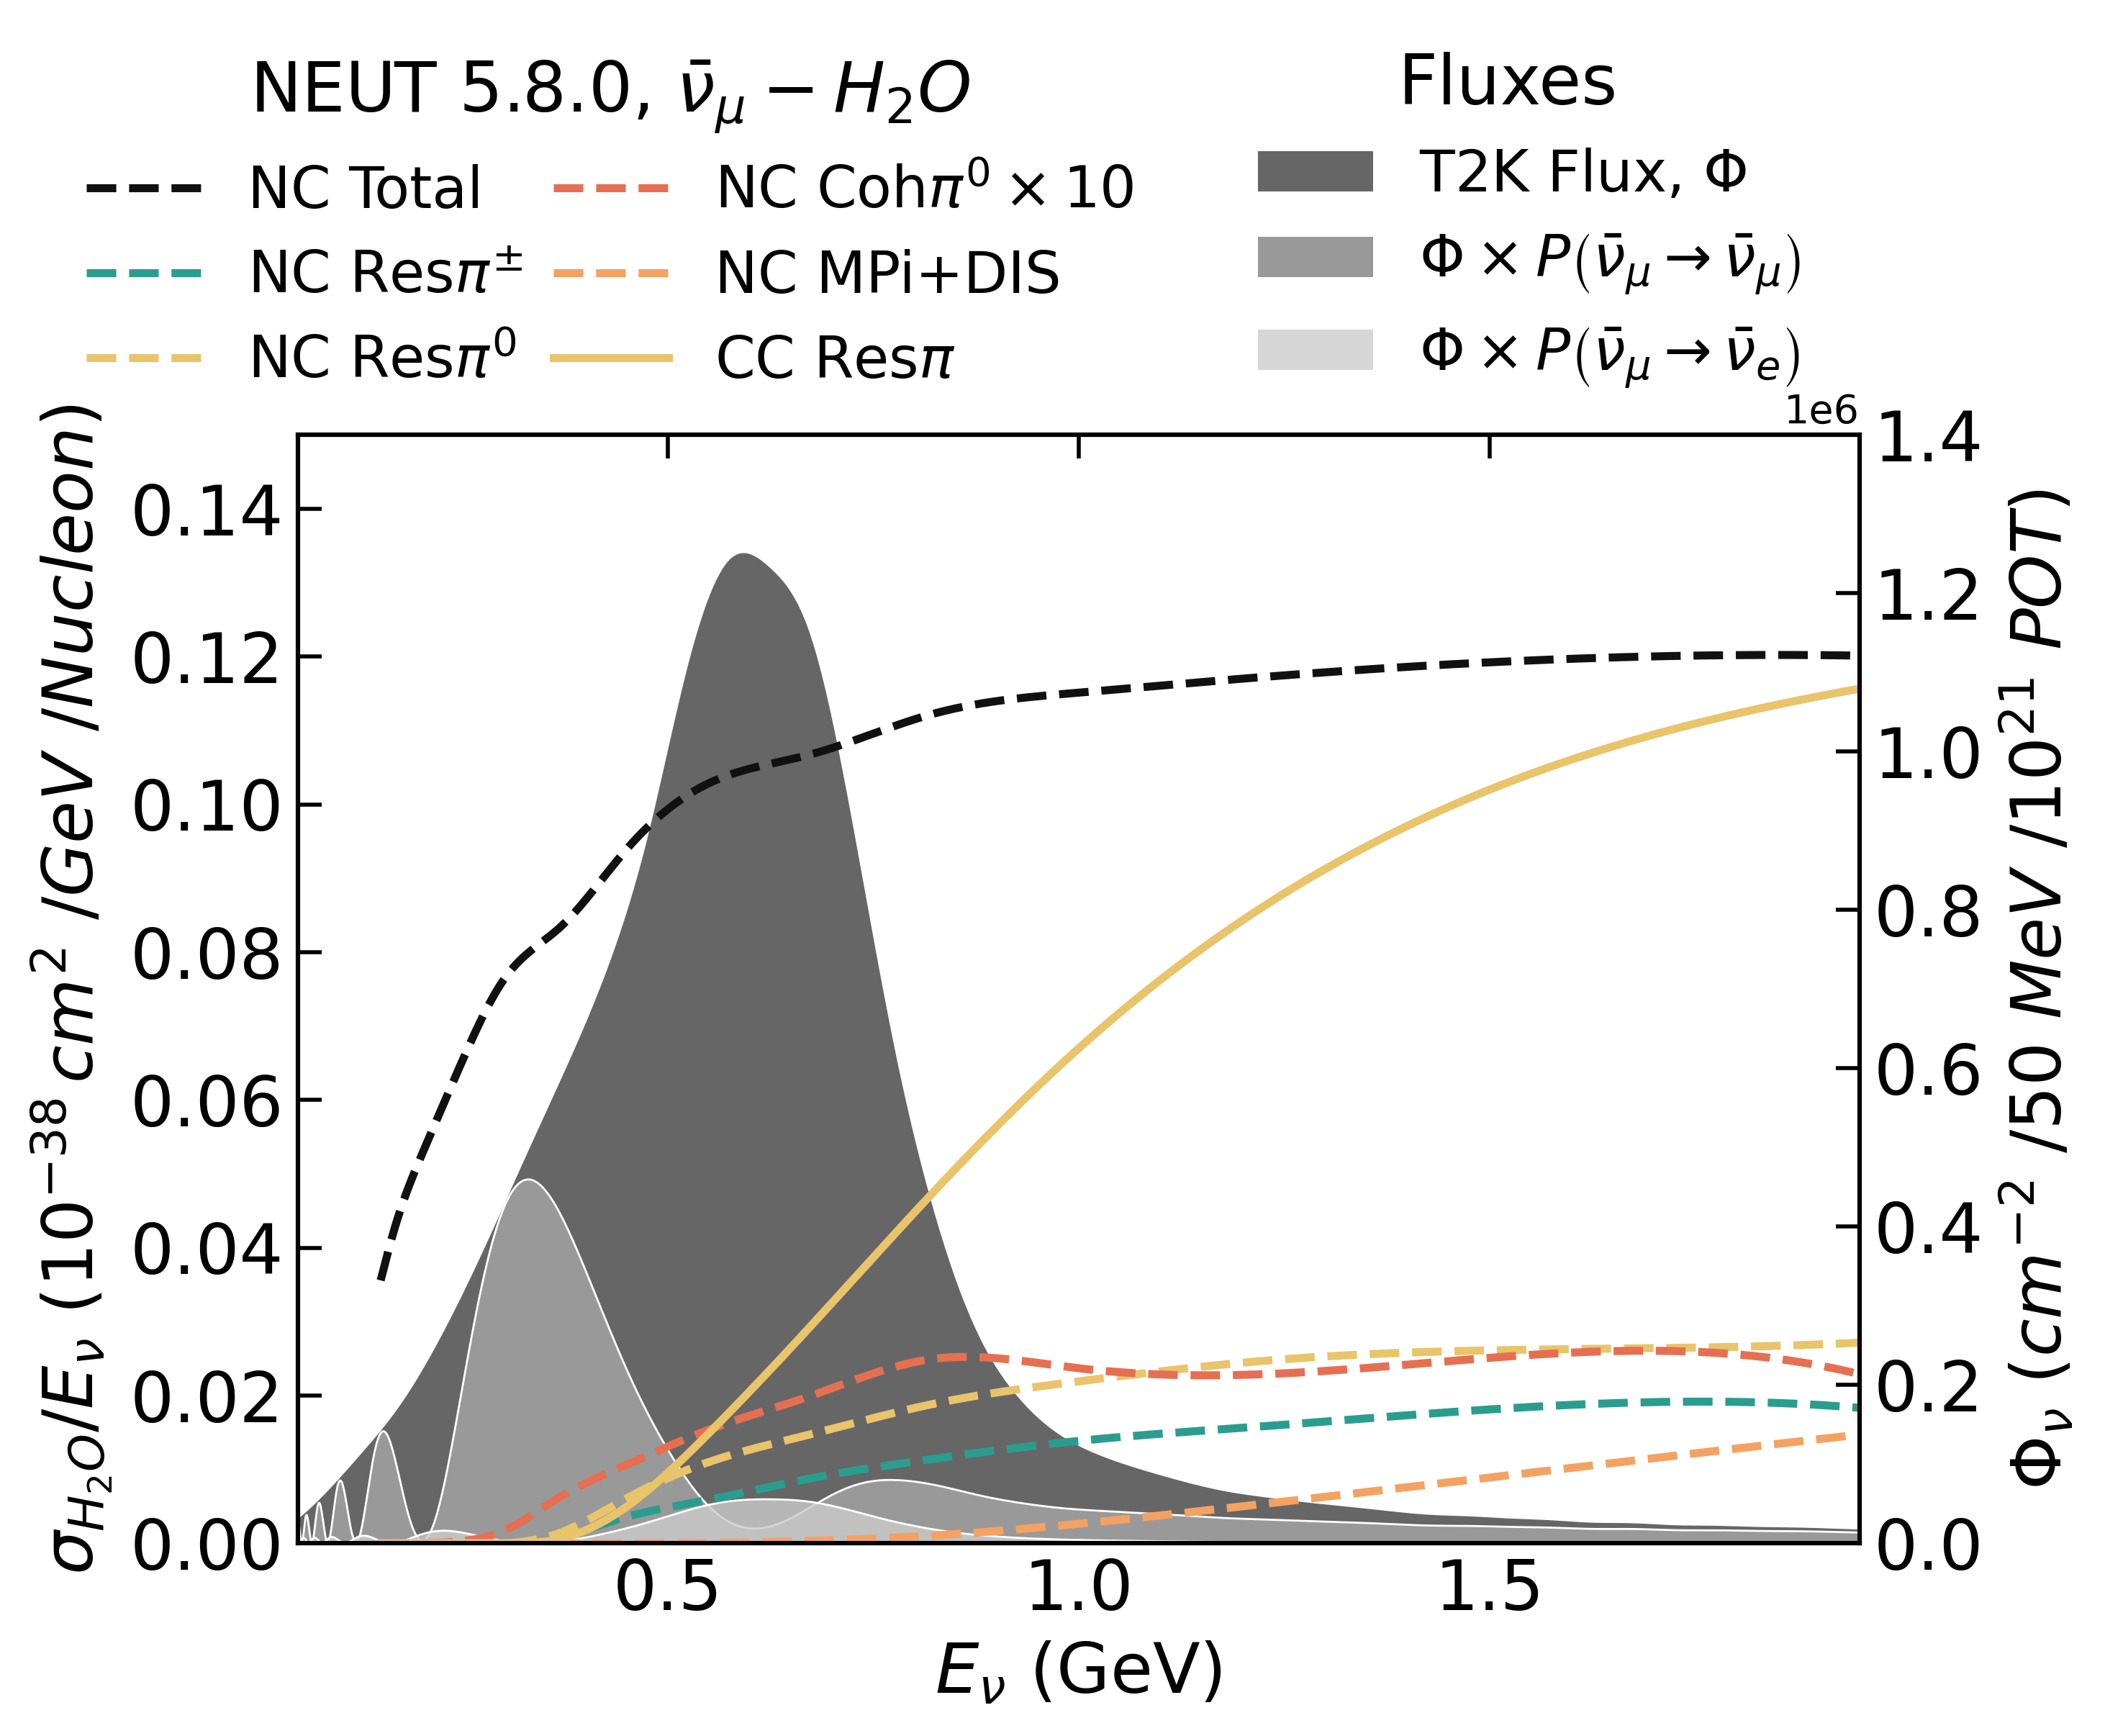

In [67]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(111)

ax1.set_xlim([0.05,1.95])
ax1.set_ylim([0,1.4E6])

ax1.fill(t2k_logdx,t2k_logdy, facecolor="#666",zorder=3, label="T2K Flux, $\Phi$")
ax1.fill(t2k_logdx,dosc_t2knb[1:],facecolor="#999",zorder=3, label=r"$\Phi\times{P}\left(\bar{\nu}_\mu\rightarrow\bar{\nu}_\mu\right)$")
ax1.plot(t2k_logdx,dosc_t2knb[1:],color="#FFF",linestyle="solid",linewidth=0.5,zorder=3)
ax1.fill(t2k_logdx,aosc_t2knb[1:],facecolor="#cccc",zorder=4, label=r"$\Phi\times{P}\left(\bar{\nu}_\mu\rightarrow\bar{\nu}_{e}\right)$")
ax1.plot(t2k_logdx,aosc_t2knb[1:],color="#FFF",linestyle="solid",linewidth=0.5,zorder=4)

ax1.legend(bbox_to_anchor=(0.6, 1.02, 0.35, .102), loc='lower left',
                      ncol=1, mode="expand", borderaxespad=0.,
          title="Fluxes", fontsize="x-large", title_fontsize="xx-large")

ax1.set_ylabel(r"$\Phi_{\nu}\ ({cm}^{-2}\ /50\ {MeV}\ /10^{21}\ {POT})$",fontsize="xx-large")
ax1.set_xlabel(r"$E_{\nu}$ (GeV)",fontsize="xx-large",loc="center")
ax1.tick_params(axis='x', labelsize="xx-large")

ax2 = ax1.twinx()
# CC plots: CC total, CCQE, CC 2p2h, CC Res pi, CC multi-pi + DIS, NC Total
# NC plot: NC total,  NC Res pi+/-, NC Res pi0, NC Coh pi0, NC multi-pi + DIS, CC Res pi
xsec_topo_smoothb.mpl().plot_sum(columns=NCb_categories, plot_axis=ax2, linewidth=2, color="#111", linestyle="dashed",label="NC Total")
xsec_topo_smoothb.mpl().plot(column="NCRes$\pi^{\pm}$b", plot_axis=ax2, linewidth=2,color="#2a9d8f", linestyle="dashed",label="NC Res$\pi^{\pm}$")
xsec_topo_smoothb.mpl().plot(column="NCRes$\pi^{0}$b", plot_axis=ax2, linewidth=2,color="#e9c46a", linestyle="dashed",label="NC Res$\pi^{0}$")
xsec_topo_smoothb.mpl().plot(column="NCCoh$\pi^{0}$b", yscale=10,plot_axis=ax2, linewidth=2,color="#e76f51", linestyle="dashed",label=r"NC Coh$\pi^{0}\times 10$")
xsec_topo_smoothb.mpl().plot(column="NCMPi+DISb", plot_axis=ax2, linewidth=2,color="#f4a261", linestyle="dashed",label="NC MPi+DIS")
xsec_topo_smoothb.mpl().plot(column="CCRes$\pi$b", plot_axis=ax2, linewidth=2,color="#e9c46a", linestyle="solid", label="CC Res$\pi$")

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis='y', labelsize="xx-large")

ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim([0,0.15])
ax2.tick_params(axis='y', labelsize="xx-large")

ax2.set_ylabel(r"$\sigma_{{H}_{2}{O}}/E_{\nu}\ (10^{-38}\,{cm}^{2}\ /{GeV}\ /{Nucleon})$",fontsize="xx-large",loc="center")

ax2.legend(bbox_to_anchor=(-0.15, 1.02, 0.7, .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0.,
          title=r"NEUT 5.8.0, $\bar{\nu}_{\mu}-{H}_{2}{O}$",
          fontsize="x-large", title_fontsize="xx-large")
mydpi=400
# plt.figure(figsize=(800/mydpi, 800/mydpi), dpi=mydpi)
plt.savefig("fortailin_mode_NC_nub.png", bbox_inches='tight', dpi=mydpi)
plt.show()

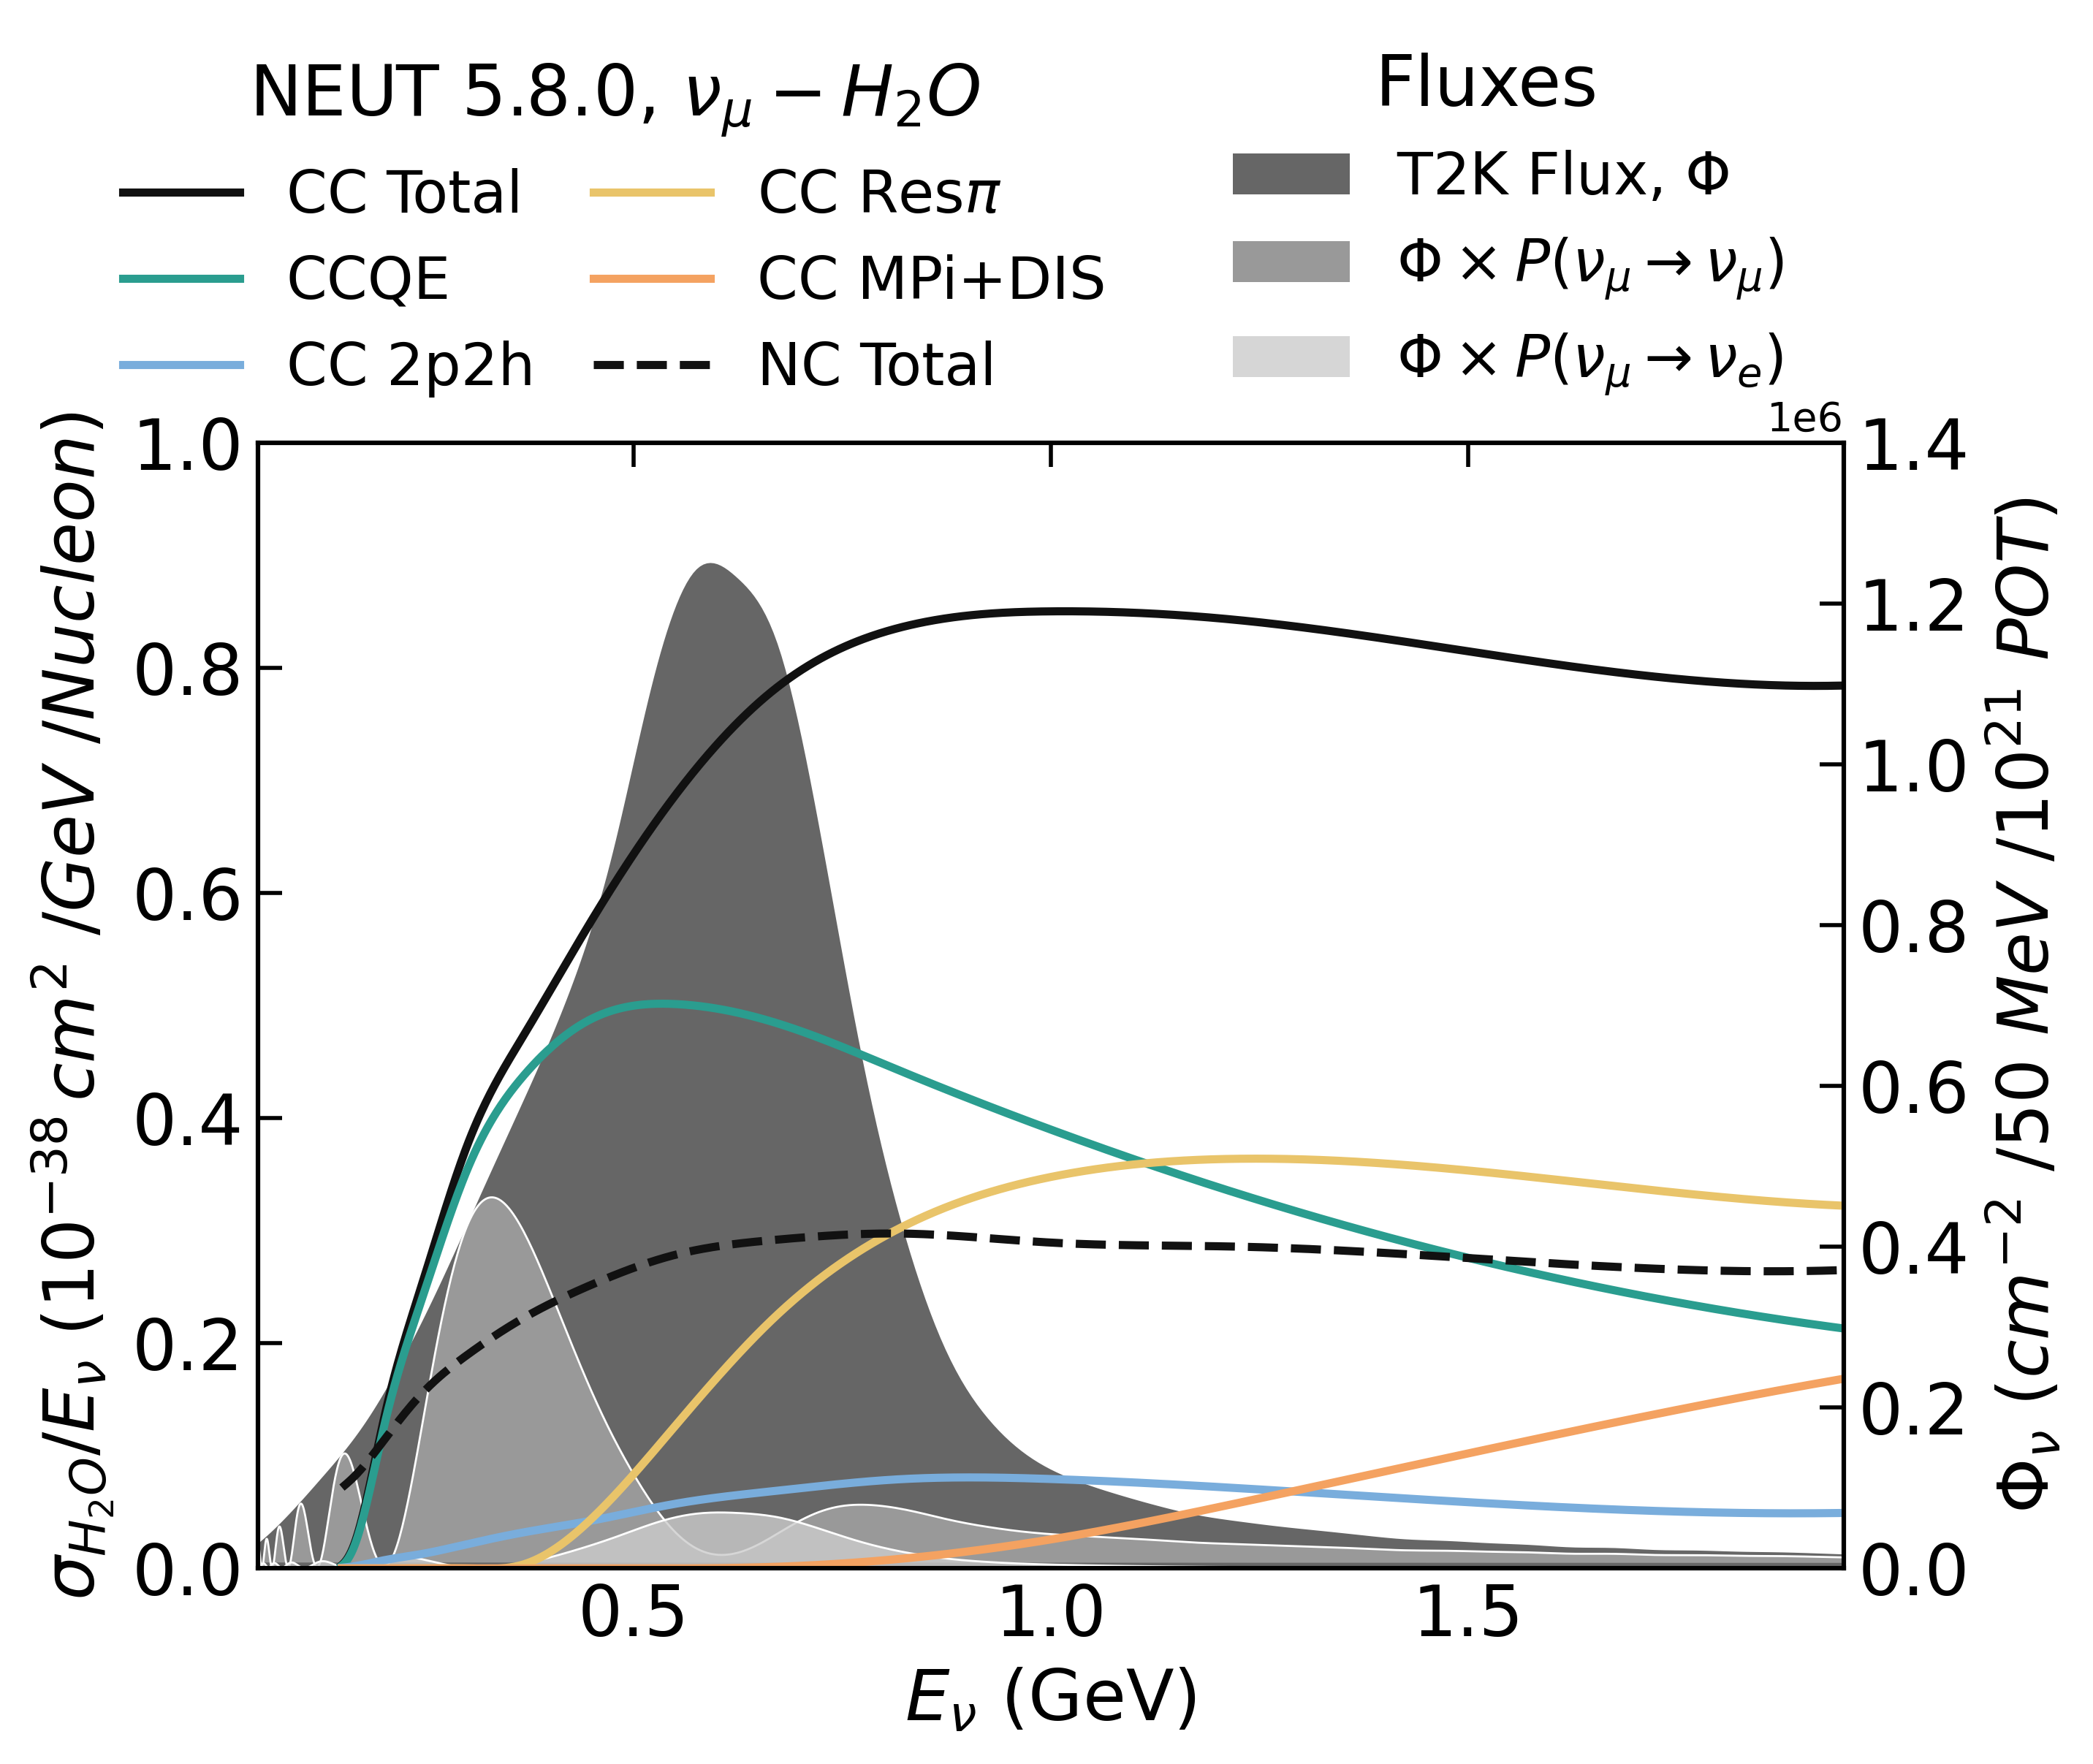

In [64]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(111)

ax1.set_xlim([0.05,1.95])
ax1.set_ylim([0,1.4E6])

ax1.fill(t2k_logdx,t2k_logdy, facecolor="#666",zorder=3, label="T2K Flux, $\Phi$")
ax1.fill(t2k_logdx,dosc_t2kn,facecolor="#999",zorder=3, label=r"$\Phi\times{P}\left(\nu_\mu\rightarrow\nu_\mu\right)$")
ax1.plot(t2k_logdx,dosc_t2kn,color="#FFF",linestyle="solid",linewidth=0.5,zorder=3)
ax1.fill(t2k_logdx,aosc_t2kn,facecolor="#cccc",zorder=4, label=r"$\Phi\times{P}\left(\nu_\mu\rightarrow\nu_{e}\right)$")
ax1.plot(t2k_logdx,aosc_t2kn,color="#FFF",linestyle="solid",linewidth=0.5,zorder=4)

ax1.legend(bbox_to_anchor=(0.6, 1.02, 0.35, .102), loc='lower left',
                      ncol=1, mode="expand", borderaxespad=0.,
          title="Fluxes", fontsize="x-large", title_fontsize="xx-large")

ax1.set_ylabel(r"$\Phi_{\nu}\ ({cm}^{-2}\ /50\ {MeV}\ /10^{21}\ {POT})$",fontsize="xx-large")
ax1.set_xlabel(r"$E_{\nu}$ (GeV)",fontsize="xx-large",loc="center")
ax1.tick_params(axis='x', labelsize="xx-large")

ax2 = ax1.twinx()
# CC plots: CC total, CCQE, CC 2p2h, CC Res pi, CC multi-pi + DIS, NC Total
# NC plot: NC total,  NC Res pi+/-, NC Res pi0, NC Coh pi0, NC multi-pi + DIS, CC Res pi
xsec_topo_smooth.mpl().plot_sum(columns=CC_categories, plot_axis=ax2, linewidth=2, color="#111",label="CC Total")
xsec_topo_smooth.mpl().plot(column="CCQE", plot_axis=ax2, linewidth=2,color="#2a9d8f",label="CCQE")
xsec_topo_smooth.mpl().plot(column="CC 2p2h", plot_axis=ax2, linewidth=2,color="#79addc",label="CC 2p2h")
xsec_topo_smooth.mpl().plot(column="CCRes$\pi$", plot_axis=ax2, linewidth=2,color="#e9c46a",label="CC Res$\pi$")
xsec_topo_smooth.mpl().plot(column="CCMPi+DIS", plot_axis=ax2, linewidth=2,color="#f4a261",label="CC MPi+DIS")
xsec_topo_smooth.mpl().plot_sum(columns=NC_categories, plot_axis=ax2, linewidth=2,color="#111", linestyle="dashed", label="NC Total")

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis='y', labelsize="xx-large")

ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim([0,1])
ax2.tick_params(axis='y', labelsize="xx-large")

ax2.set_ylabel(r"$\sigma_{{H}_{2}{O}}/E_{\nu}\ (10^{-38}\,{cm}^{2}\ /{GeV}\ /{Nucleon})$",fontsize="xx-large",loc="center")

ax2.legend(bbox_to_anchor=(-0.1, 1.02, 0.65, .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0.,
          title=r"NEUT 5.8.0, $\nu_{\mu}-{H}_{2}{O}$",
          fontsize="x-large", title_fontsize="xx-large")
mydpi=400
# plt.figure(figsize=(800/mydpi, 800/mydpi), dpi=mydpi)
plt.savefig("fortailin_mode_CC.png", bbox_inches='tight', dpi=mydpi)
plt.show()

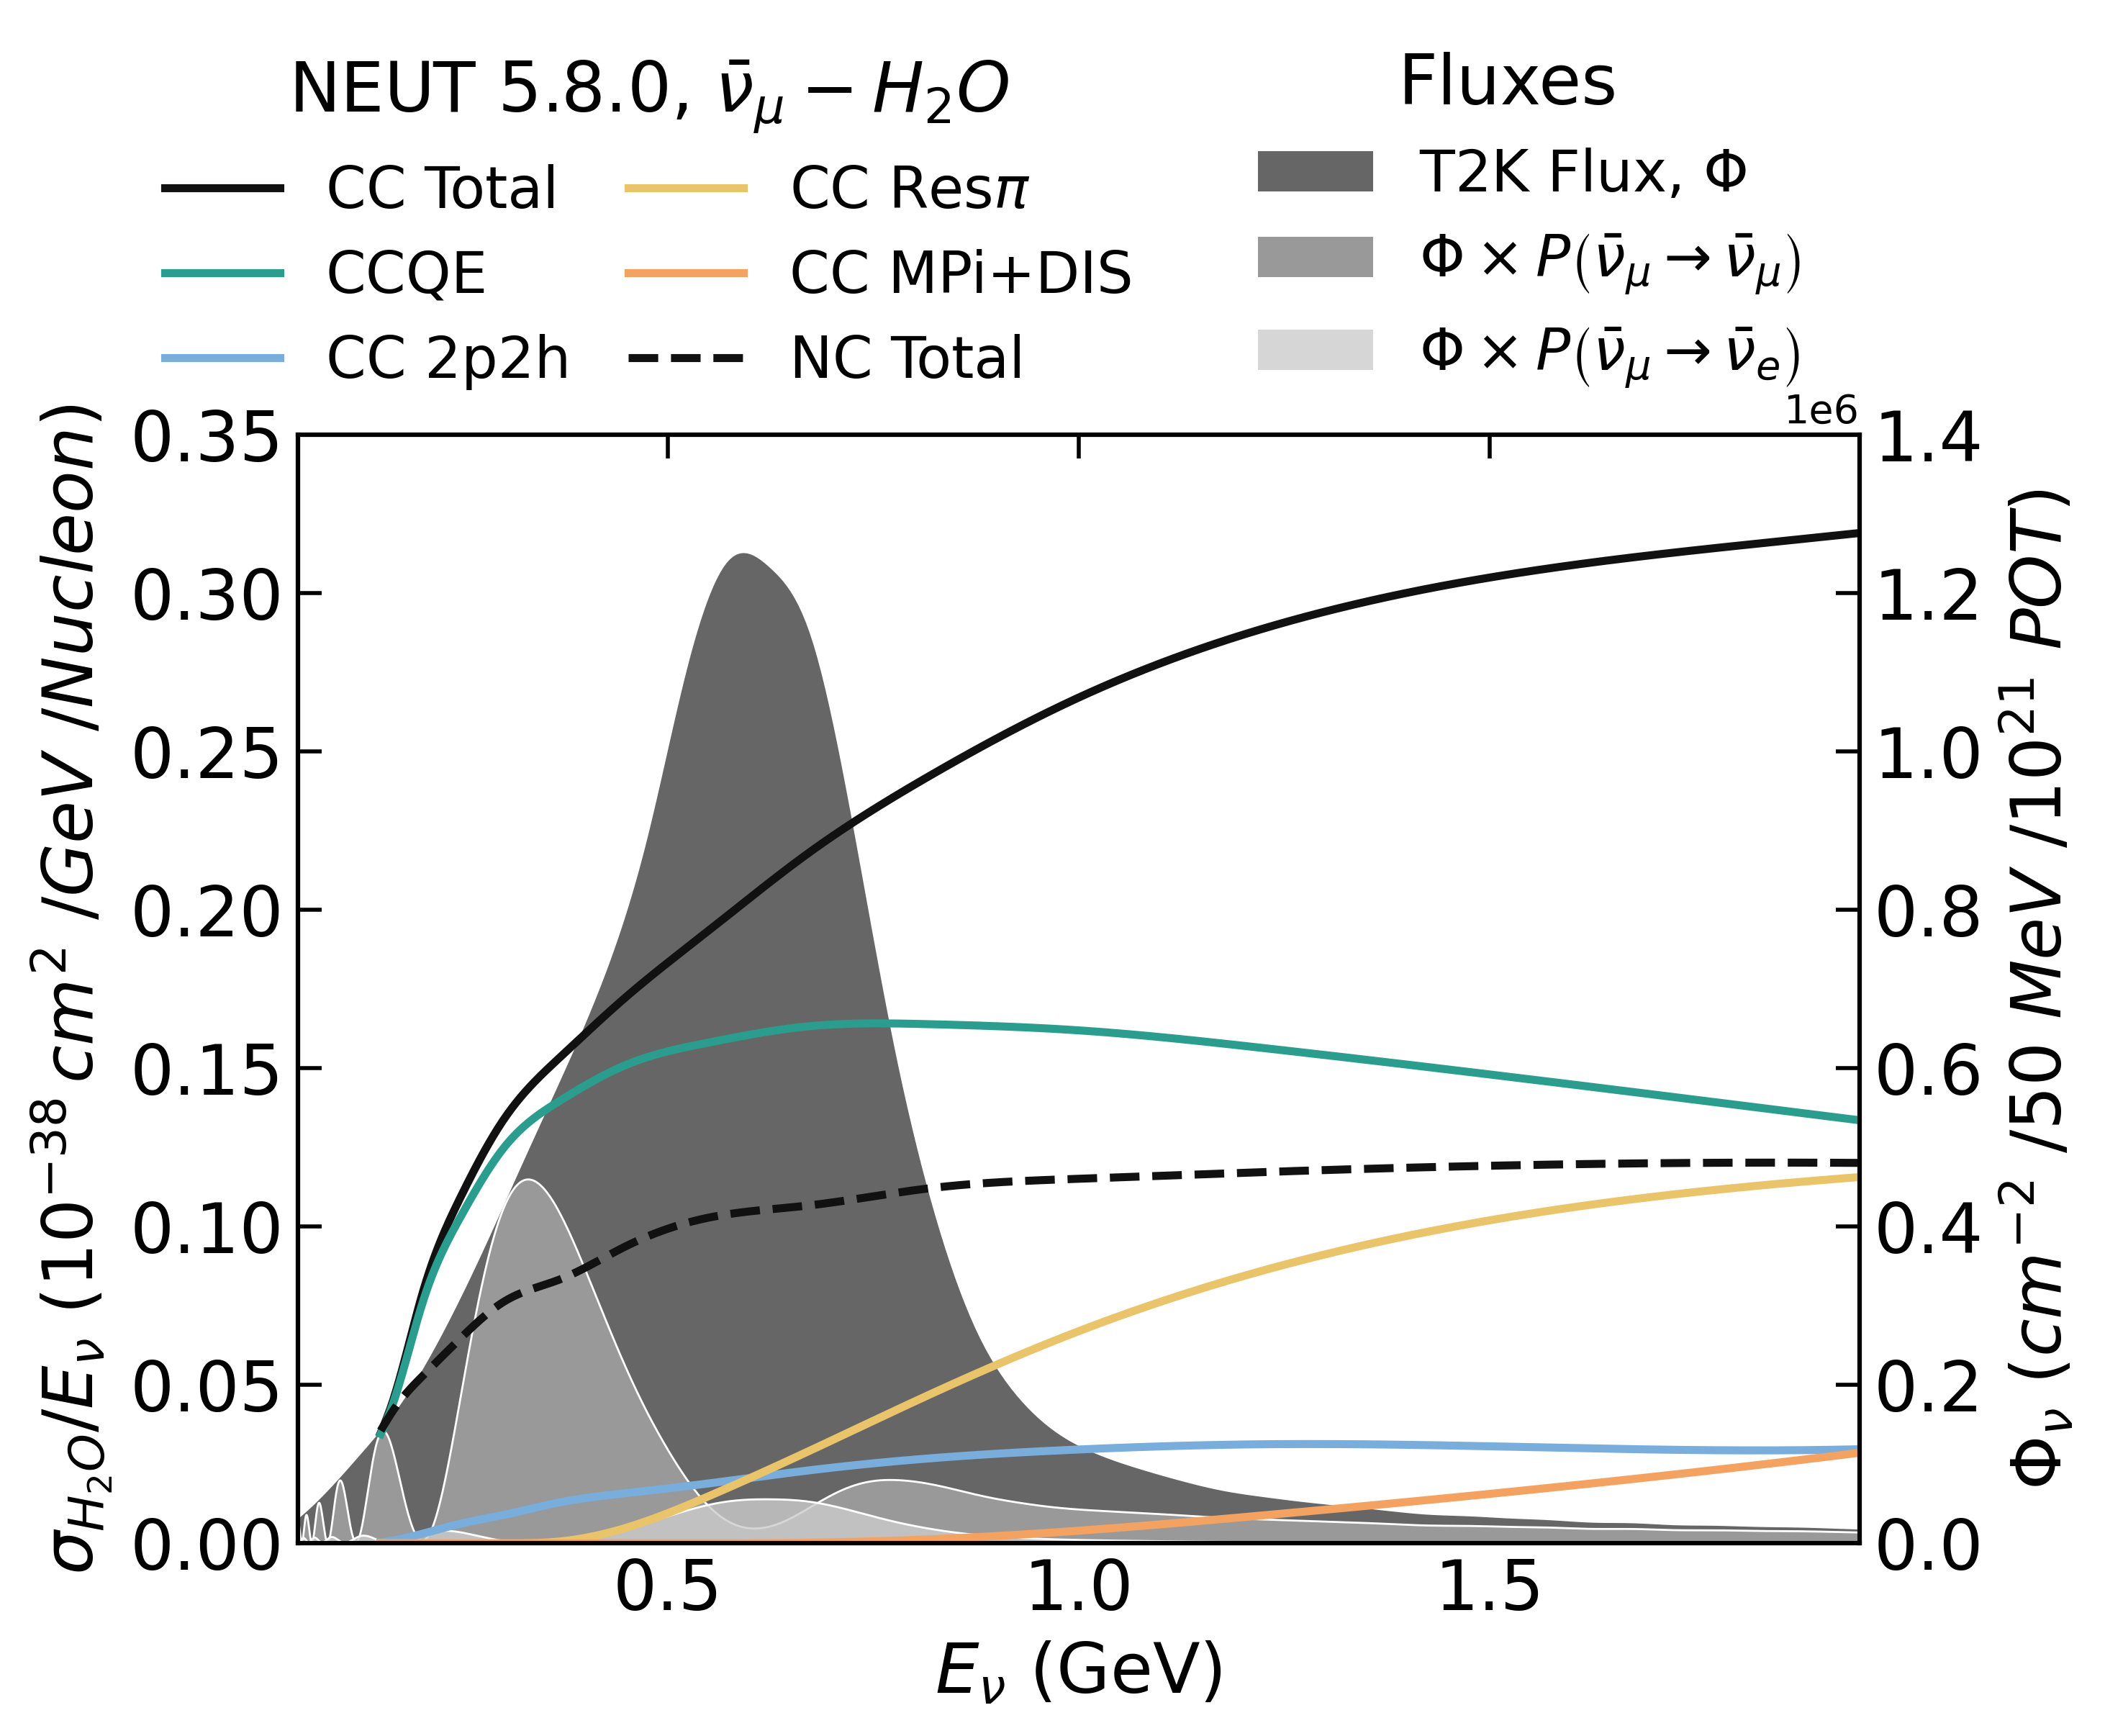

In [66]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(111)

ax1.set_xlim([0.05,1.95])
ax1.set_ylim([0,1.4E6])

ax1.fill(t2k_logdx,t2k_logdy, facecolor="#666",zorder=3, label="T2K Flux, $\Phi$")
ax1.fill(t2k_logdx,dosc_t2knb[1:],facecolor="#999",zorder=3, label=r"$\Phi\times{P}\left(\bar{\nu}_\mu\rightarrow\bar{\nu}_\mu\right)$")
ax1.plot(t2k_logdx,dosc_t2knb[1:],color="#FFF",linestyle="solid",linewidth=0.5,zorder=3)
ax1.fill(t2k_logdx,aosc_t2knb[1:],facecolor="#cccc",zorder=4, label=r"$\Phi\times{P}\left(\bar{\nu}_\mu\rightarrow\bar{\nu}_{e}\right)$")
ax1.plot(t2k_logdx,aosc_t2knb[1:],color="#FFF",linestyle="solid",linewidth=0.5,zorder=4)

ax1.legend(bbox_to_anchor=(0.6, 1.02, 0.35, .102), loc='lower left',
                      ncol=1, mode="expand", borderaxespad=0.,
          title="Fluxes", fontsize="x-large", title_fontsize="xx-large")

ax1.set_ylabel(r"$\Phi_{\nu}\ ({cm}^{-2}\ /50\ {MeV}\ /10^{21}\ {POT})$",fontsize="xx-large")
ax1.set_xlabel(r"$E_{\nu}$ (GeV)",fontsize="xx-large",loc="center")
ax1.tick_params(axis='x', labelsize="xx-large")

ax2 = ax1.twinx()
# CC plots: CC total, CCQE, CC 2p2h, CC Res pi, CC multi-pi + DIS, NC Total
# NC plot: NC total,  NC Res pi+/-, NC Res pi0, NC Coh pi0, NC multi-pi + DIS, CC Res pi
xsec_topo_smoothb.mpl().plot_sum(columns=CCb_categories, plot_axis=ax2, linewidth=2, color="#111",label="CC Total")
xsec_topo_smoothb.mpl().plot(column="CCQEb", plot_axis=ax2, linewidth=2,color="#2a9d8f",label="CCQE")
xsec_topo_smoothb.mpl().plot(column="CC 2p2hb", plot_axis=ax2, linewidth=2,color="#79addc",label="CC 2p2h")
xsec_topo_smoothb.mpl().plot(column="CCRes$\pi$b", plot_axis=ax2, linewidth=2,color="#e9c46a",label="CC Res$\pi$")
xsec_topo_smoothb.mpl().plot(column="CCMPi+DISb", plot_axis=ax2, linewidth=2,color="#f4a261",label="CC MPi+DIS")
xsec_topo_smoothb.mpl().plot_sum(columns=NCb_categories, plot_axis=ax2, linewidth=2,color="#111", linestyle="dashed", label="NC Total")

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis='y', labelsize="xx-large")

ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim([0,0.35])
ax2.tick_params(axis='y', labelsize="xx-large")

ax2.set_ylabel(r"$\sigma_{{H}_{2}{O}}/E_{\nu}\ (10^{-38}\,{cm}^{2}\ /{GeV}\ /{Nucleon})$",fontsize="xx-large",loc="center")

ax2.legend(bbox_to_anchor=(-0.1, 1.02, 0.65, .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0.,
          title=r"NEUT 5.8.0, $\bar{\nu}_{\mu}-{H}_{2}{O}$",
          fontsize="x-large", title_fontsize="xx-large")
mydpi=400
# plt.figure(figsize=(800/mydpi, 800/mydpi), dpi=mydpi)
plt.savefig("fortailin_mode_CC_nub.png", bbox_inches='tight', dpi=mydpi)
plt.show()